# General setup

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix, classification_report)
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

# My three classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# For reproducibility
RANDOM_SEED = 42

Create functions

In [3]:
def get_classifiers():
    """Return dictionary of classifiers with initial parameters"""
    classifiers = {
        'Random Forest': RandomForestClassifier(
            n_estimators=100,  # Start with 100 trees
            random_state=RANDOM_SEED,
            n_jobs=-1  # Use all CPU cores
        ),
        
        'Neural Network': MLPClassifier(
            hidden_layer_sizes=(100,),  # Start with one hidden layer
            max_iter=1000,
            random_state=RANDOM_SEED
        ),
        
        'SVM': SVC(
            kernel='rbf',
            probability=True,  # Needed for ROC curves
            random_state=RANDOM_SEED
        )
    }
    return classifiers

# Function to create different train-test splits
def create_splits(X, y):
    """Create different train-test splits (20-80, 50-50, 80-20)"""
    splits = {}
    
    # 20-80 split
    X_train_20, X_test_80, y_train_20, y_test_80 = train_test_split(
        X, y, train_size=0.2, random_state=RANDOM_SEED)
    splits['20-80'] = (X_train_20, X_test_80, y_train_20, y_test_80)
    
    # 50-50 split
    X_train_50, X_test_50, y_train_50, y_test_50 = train_test_split(
        X, y, train_size=0.5, random_state=RANDOM_SEED)
    splits['50-50'] = (X_train_50, X_test_50, y_train_50, y_test_50)
    
    # 80-20 split
    X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(
        X, y, train_size=0.8, random_state=RANDOM_SEED)
    splits['80-20'] = (X_train_80, X_test_20, y_train_80, y_test_20)
    
    return splits

In [4]:
# Define parameter grids for cross-validation
def get_param_grids():
    """Define simplified parameter grids with focus on preventing overfitting"""
    param_grids = {
        'Random Forest': {
            'n_estimators': [100],  
            'max_depth': [3, 5, 10],  
            'min_samples_split': [5, 10],  
            'max_features': ['sqrt']  
        },
        'Neural Network': {
            'hidden_layer_sizes': [(10,), (20,)],  
            'alpha': [0.01, 0.1],  
            'learning_rate_init': [0.01],
            'early_stopping': [True],
            'validation_fraction': [0.2]
        },
        'SVM': {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto'],
            'kernel': ['rbf']  
        }
    }
    return param_grids

In [5]:
def plot_classifier_results(grid_searches, split_name):
    """
    Create visualizations with parameter details, performance plots, and heatmaps
    """
    for clf_name, grid_search in grid_searches.items():
        # Get cross validation results
        results = pd.DataFrame(grid_search.cv_results_)
        param_cols = [col for col in results.columns if col.startswith('param_')]
        
        # Create figure with gridspec for flexible subplot layout
        if len(param_cols) >= 2:  # If we can make a heatmap
            fig = plt.figure(figsize=(15, 12))
            gs = plt.GridSpec(3, 2, height_ratios=[2, 2, 1])
        else:
            fig = plt.figure(figsize=(15, 10))
            gs = plt.GridSpec(2, 2, height_ratios=[2, 1])
        
        # 1. Performance Scatter Plot (top left)
        ax1 = fig.add_subplot(gs[0, 0])
        scatter = ax1.scatter(range(len(results)), results.mean_test_score, 
                            label='Cross-validation score', alpha=0.7)
        ax1.scatter(range(len(results)), results.mean_train_score, 
                   label='Training score', alpha=0.7)
        ax1.set_title(f'{clf_name} Performance by Configuration')
        ax1.set_xlabel('Configuration Index')
        ax1.set_ylabel('Score')
        ax1.legend()
        ax1.grid(True)
        
        # 2. Parameter Details Table (top right)
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.axis('off')
        
        # Create parameter details table
        param_data = results[param_cols + ['mean_test_score', 'mean_train_score']].round(3)
        param_data = param_data.rename(columns={
            col: col.replace('param_', '') for col in param_cols
        })
        
        table_data = [[f"Config {i}"] + row.tolist() 
                     for i, row in param_data.iterrows()]
        column_labels = ['Config'] + param_data.columns.tolist()
        
        table = ax2.table(cellText=table_data,
                         colLabels=column_labels,
                         loc='center',
                         cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        
        # 3. Heatmap (middle row) if we have enough parameters
        if len(param_cols) >= 2:
            ax3 = fig.add_subplot(gs[1, :])
            param1 = param_cols[0].replace('param_', '')
            param2 = param_cols[1].replace('param_', '')
            
            heatmap_data = results.pivot_table(
                values='mean_test_score',
                index=param_cols[0],
                columns=param_cols[1],
                aggfunc='mean'
            )
            
            sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', ax=ax3)
            ax3.set_title(f'{clf_name} Parameter Interaction\n{param1} vs {param2}')
            
            # Best Parameters (bottom)
            ax4 = fig.add_subplot(gs[2, :])
            ax4.axis('off')
            best_params_text = (f"Best Parameters:\n{grid_search.best_params_}\n\n"
                              f"Best Score: {grid_search.best_score_:.3f}")
            ax4.text(0.5, 0.5, best_params_text,
                    ha='center', va='center',
                    fontfamily='monospace',
                    bbox=dict(facecolor='white', alpha=0.8))
        else:
            # Best Parameters (bottom) when no heatmap
            ax3 = fig.add_subplot(gs[1, :])
            ax3.axis('off')
            best_params_text = (f"Best Parameters:\n{grid_search.best_params_}\n\n"
                              f"Best Score: {grid_search.best_score_:.3f}")
            ax3.text(0.5, 0.5, best_params_text,
                    ha='center', va='center',
                    fontfamily='monospace',
                    bbox=dict(facecolor='white', alpha=0.8))
        
        plt.suptitle(f'Classifier Performance Analysis - {split_name} Split\n{clf_name}',
                    fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()

def run_experiment_with_cv(X, y, trial_num):
    """Run experiment with cross-validation and visualization"""
    results = []
    param_grids = get_param_grids()
    splits = create_splits(X, y)
    base_classifiers = get_classifiers()
    
    for split_name, (X_train, X_test, y_train, y_test) in splits.items():
        print(f"\nProcessing split: {split_name}")
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Store grid search results for visualization
        split_grid_searches = {}
        
        for clf_name, base_clf in tqdm(base_classifiers.items(), 
                                     desc=f'Trial {trial_num+1}, Split {split_name}'):
            # Perform GridSearchCV
            grid_search = GridSearchCV(
                estimator=base_clf,
                param_grid=param_grids[clf_name],
                cv=5,
                scoring='roc_auc',
                n_jobs=-1,
                return_train_score=True
            )
            
            # Fit and get best model
            grid_search.fit(X_train_scaled, y_train)
            best_clf = grid_search.best_estimator_
            
            # Store grid search results
            split_grid_searches[clf_name] = grid_search
            
            # Make predictions
            y_pred = best_clf.predict(X_test_scaled)
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, best_clf.predict_proba(X_test_scaled)[:,1])
            
            # Store results
            results.append({
                'trial': trial_num,
                'split': split_name,
                'classifier': clf_name,
                'accuracy': accuracy,
                'roc_auc': roc_auc,
                'best_params': str(grid_search.best_params_)
            })
        
        # Create visualization for this split
        plot_classifier_results(split_grid_searches, split_name)
    
    return pd.DataFrame(results)

In [6]:
def plot_learning_curves(X, y, classifier_name, classifier):
    """Plot learning curves for a classifier"""
    train_sizes = np.linspace(0.1, 1.0, 5)
    
    train_sizes, train_scores, test_scores = learning_curve(
        classifier, X, y,
        train_sizes=train_sizes, cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.plot(train_sizes, test_mean, label='Cross-validation score')
    
    plt.fill_between(train_sizes, train_mean - train_std,
                     train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std,
                     test_mean + test_std, alpha=0.1)
    
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.title(f'Learning Curves for {classifier_name}')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Parkinsons dataset

Source: https://archive.ics.uci.edu/dataset/174/parkinsons

### Data setup

In [7]:
# work with zip file
import zipfile

zip_path = 'parkinsons.zip'

columns = ['name', 'MDVP:Fo', 'MDVP:Fhi', 'MDVP:Flo', 'MDVP:Jitter(%)',
           'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
           'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
           'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE',
           'DFA', 'spread1', 'spread2', 'D2', 'PPE']

# Read the data from the zip file
with zipfile.ZipFile('parkinsons.zip', 'r') as zip_ref:
    with zip_ref.open('parkinsons.data') as file:
        data = pd.read_csv(file)

# Drop the name column (ID)
data = data.drop('name', axis=1)

# Rename 'status' to 'target' for consistency with other datasets
data = data.rename(columns={'status': 'target'})

In [8]:
# Basic data exploration
print("Dataset Shape:", data.shape)
print("\nFirst few rows:")
print(data.head())

# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
print(data.describe())

# Class distribution
print("\nClass distribution:")
print(data['target'].value_counts())

Dataset Shape: (195, 23)

First few rows:
   MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  MDVP:Jitter(Abs)  \
0      119.992       157.302        74.997         0.00784           0.00007   
1      122.400       148.650       113.819         0.00968           0.00008   
2      116.682       131.111       111.555         0.01050           0.00009   
3      116.676       137.871       111.366         0.00997           0.00009   
4      116.014       141.781       110.655         0.01284           0.00011   

   MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  MDVP:Shimmer(dB)  ...  \
0   0.00370   0.00554     0.01109       0.04374             0.426  ...   
1   0.00465   0.00696     0.01394       0.06134             0.626  ...   
2   0.00544   0.00781     0.01633       0.05233             0.482  ...   
3   0.00502   0.00698     0.01505       0.05492             0.517  ...   
4   0.00655   0.00908     0.01966       0.06425             0.584  ...   

   Shimmer:DDA      NHR     HNR 

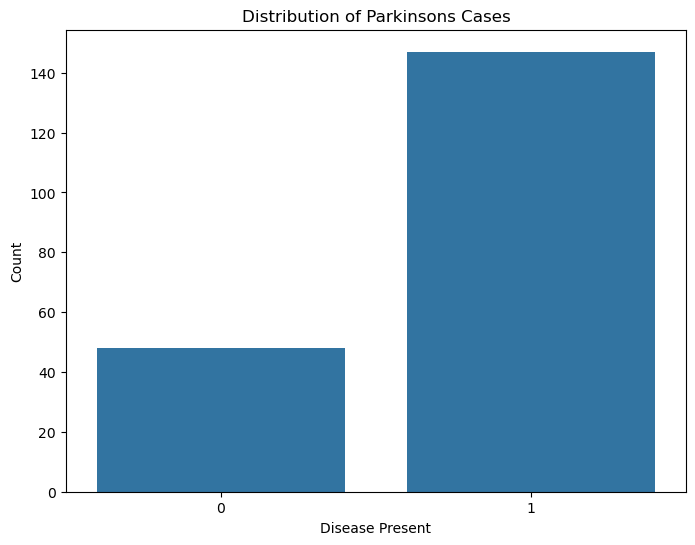

In [13]:
# Convert target to binary (0 for no disease, 1 for disease)
data['target'] = data['target'].map(lambda x: 1 if x > 0 else 0)

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='target')
plt.title('Distribution of Parkinsons Cases')
plt.xlabel('Disease Present')
plt.ylabel('Count')
plt.show()

# Split features and target
X = data.drop('target', axis=1)
y = data['target']

# Handle any missing values
if X.isnull().any().any():
    X = X.fillna(X.mean())

### Run experiments

Running experiments with cross-validation...

Processing split: 20-80


Trial 1, Split 20-80: 100%|██████████| 3/3 [00:33<00:00, 11.27s/it]


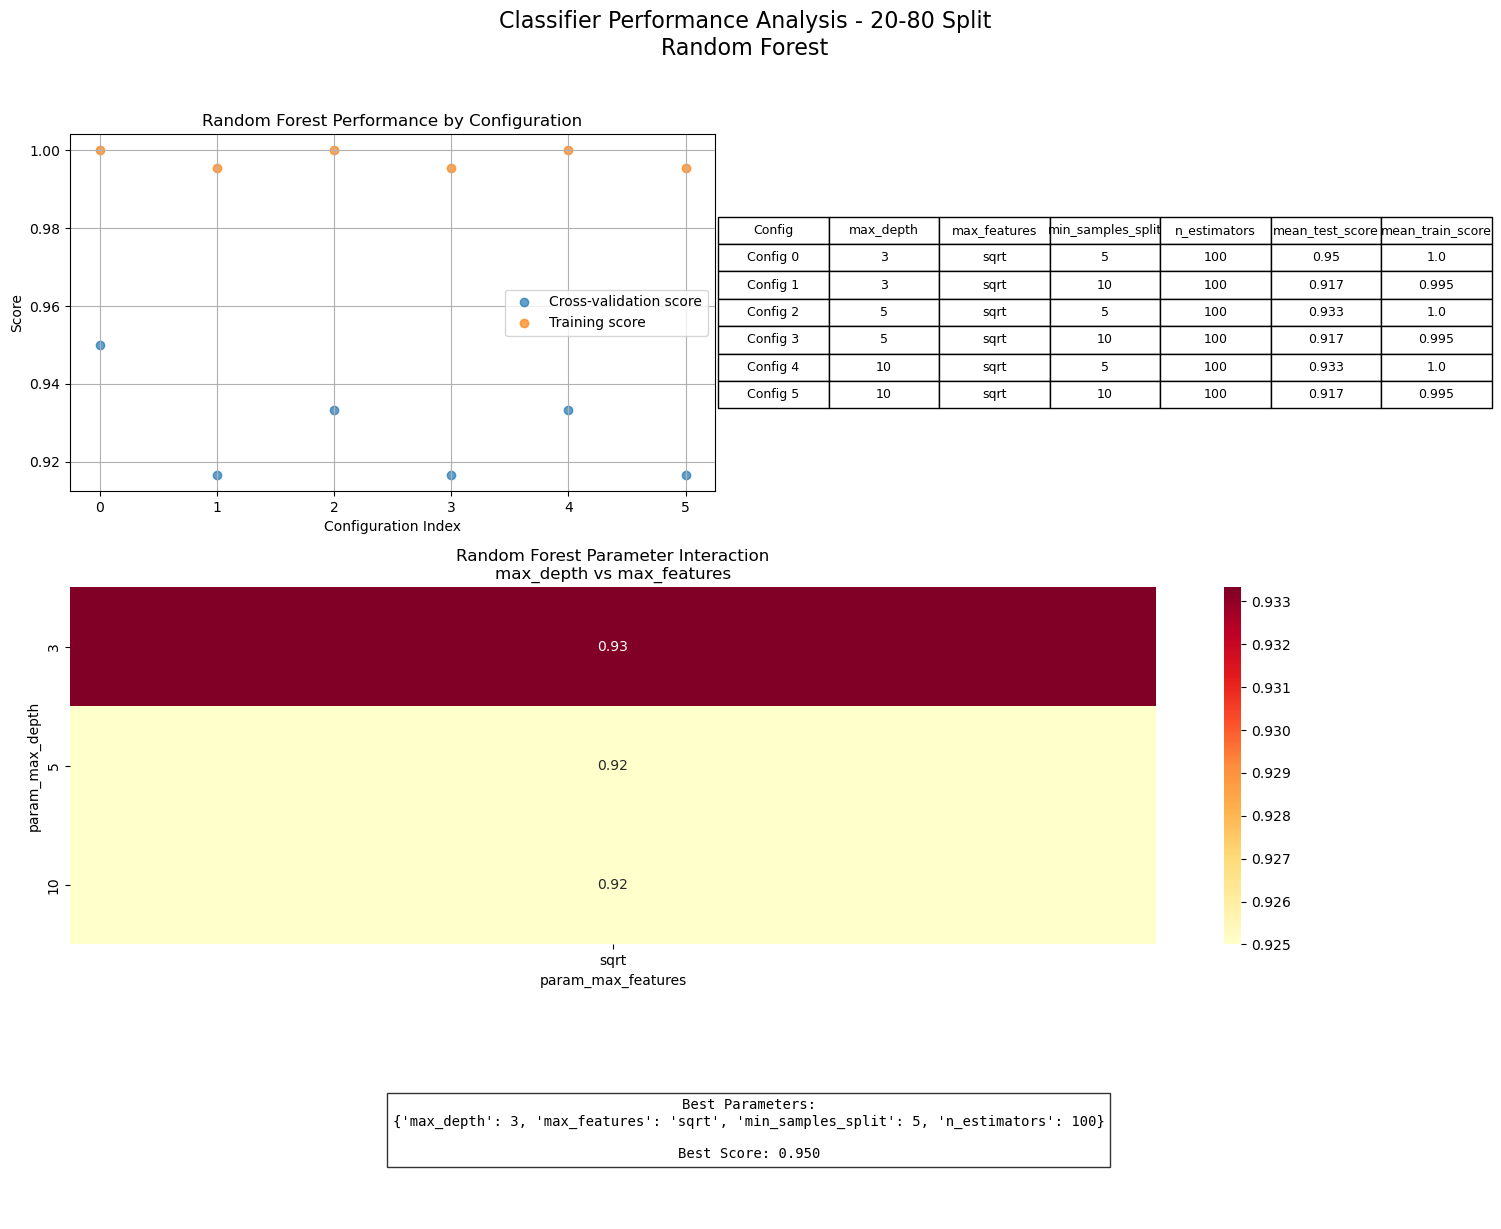

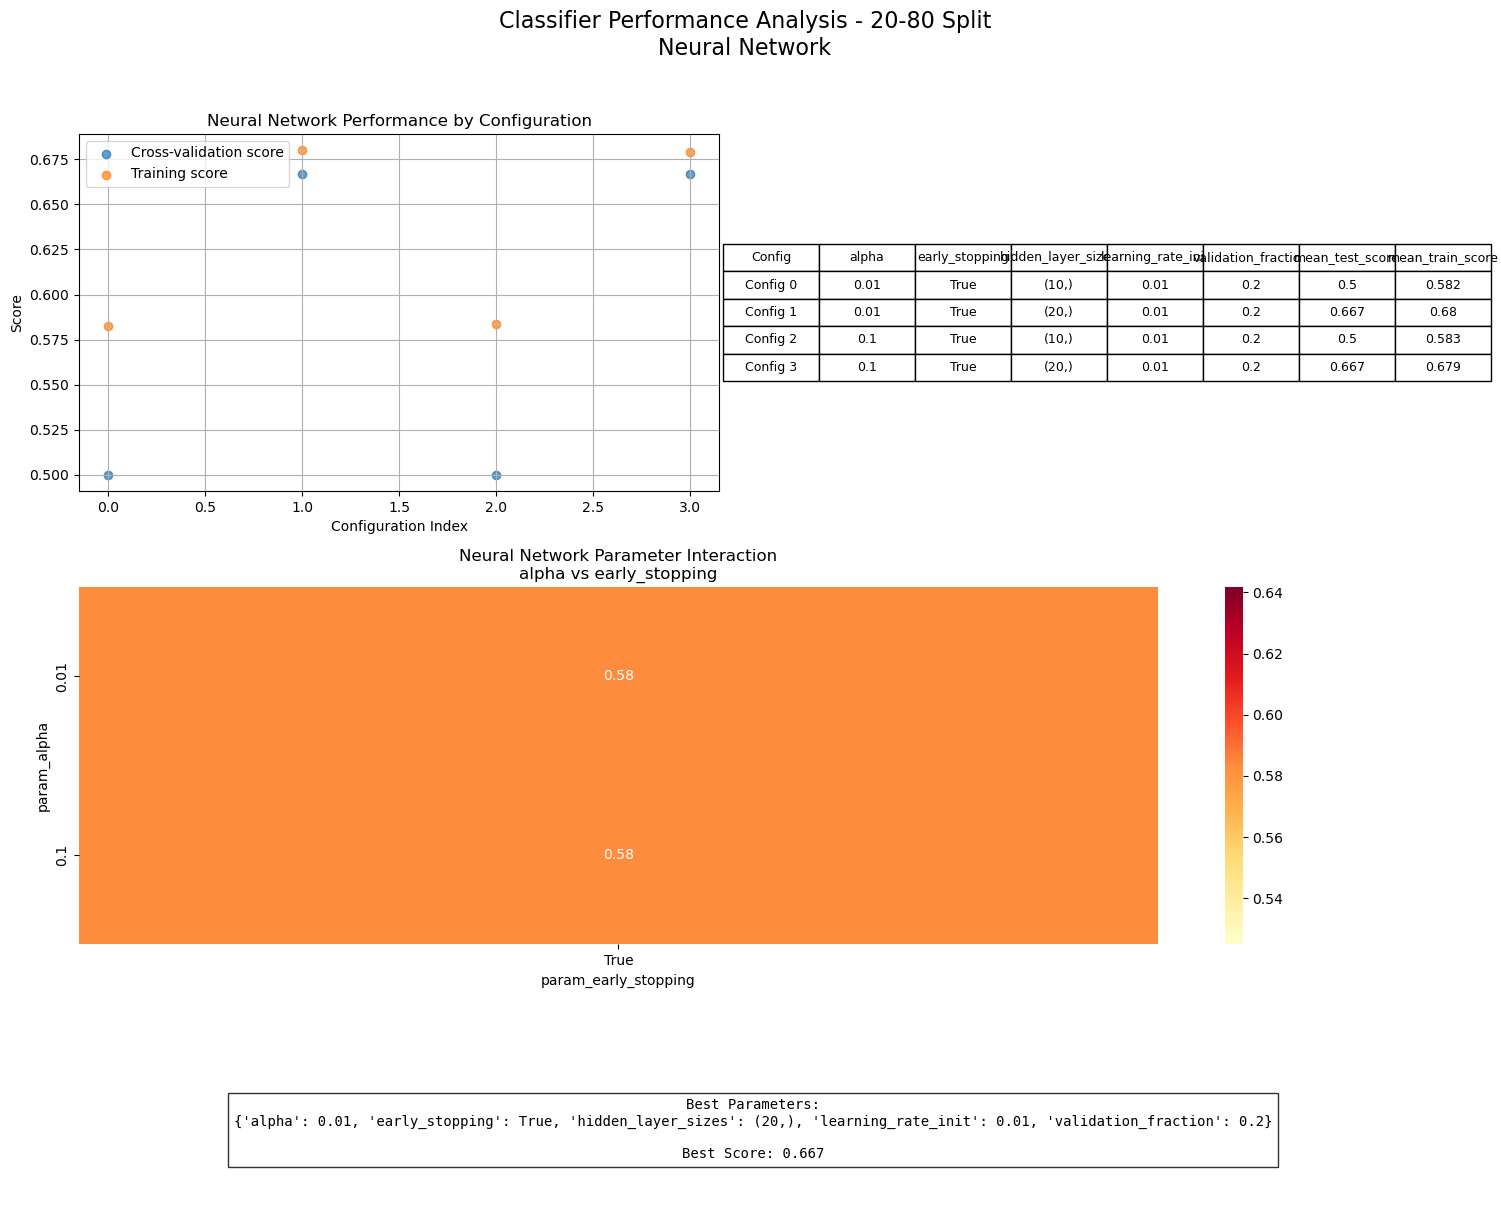

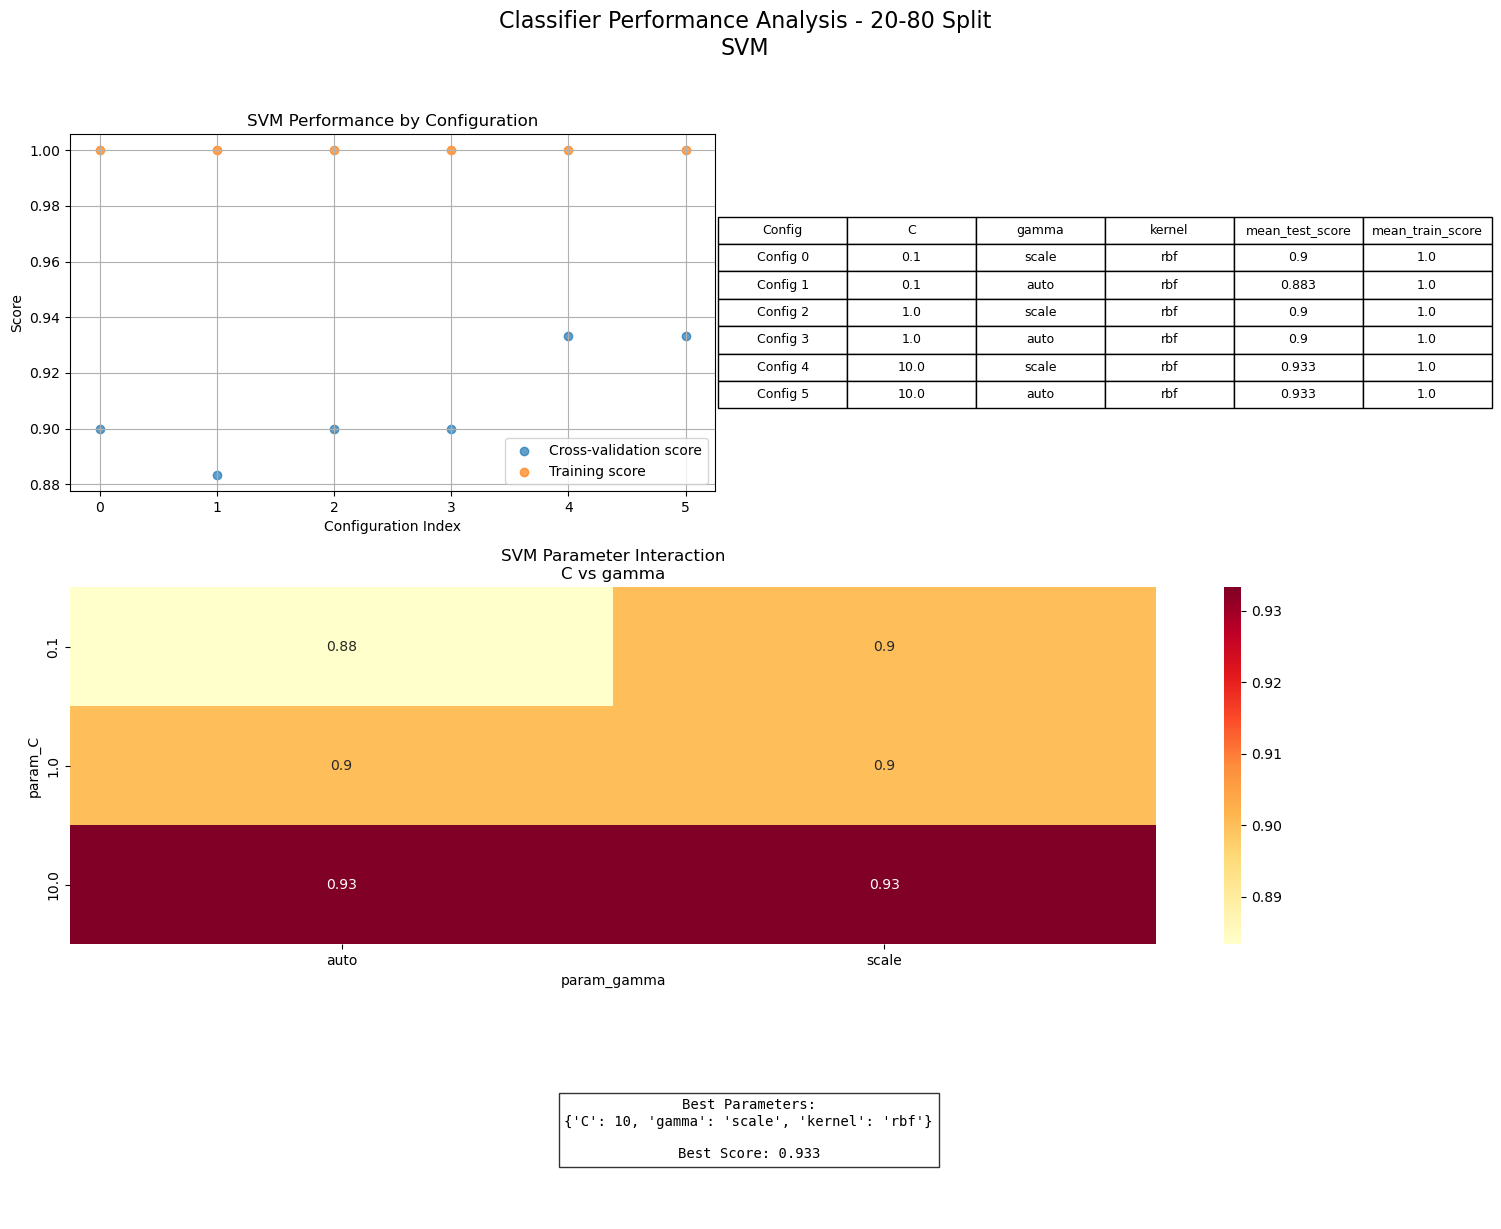


Processing split: 50-50


Trial 1, Split 50-50: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]


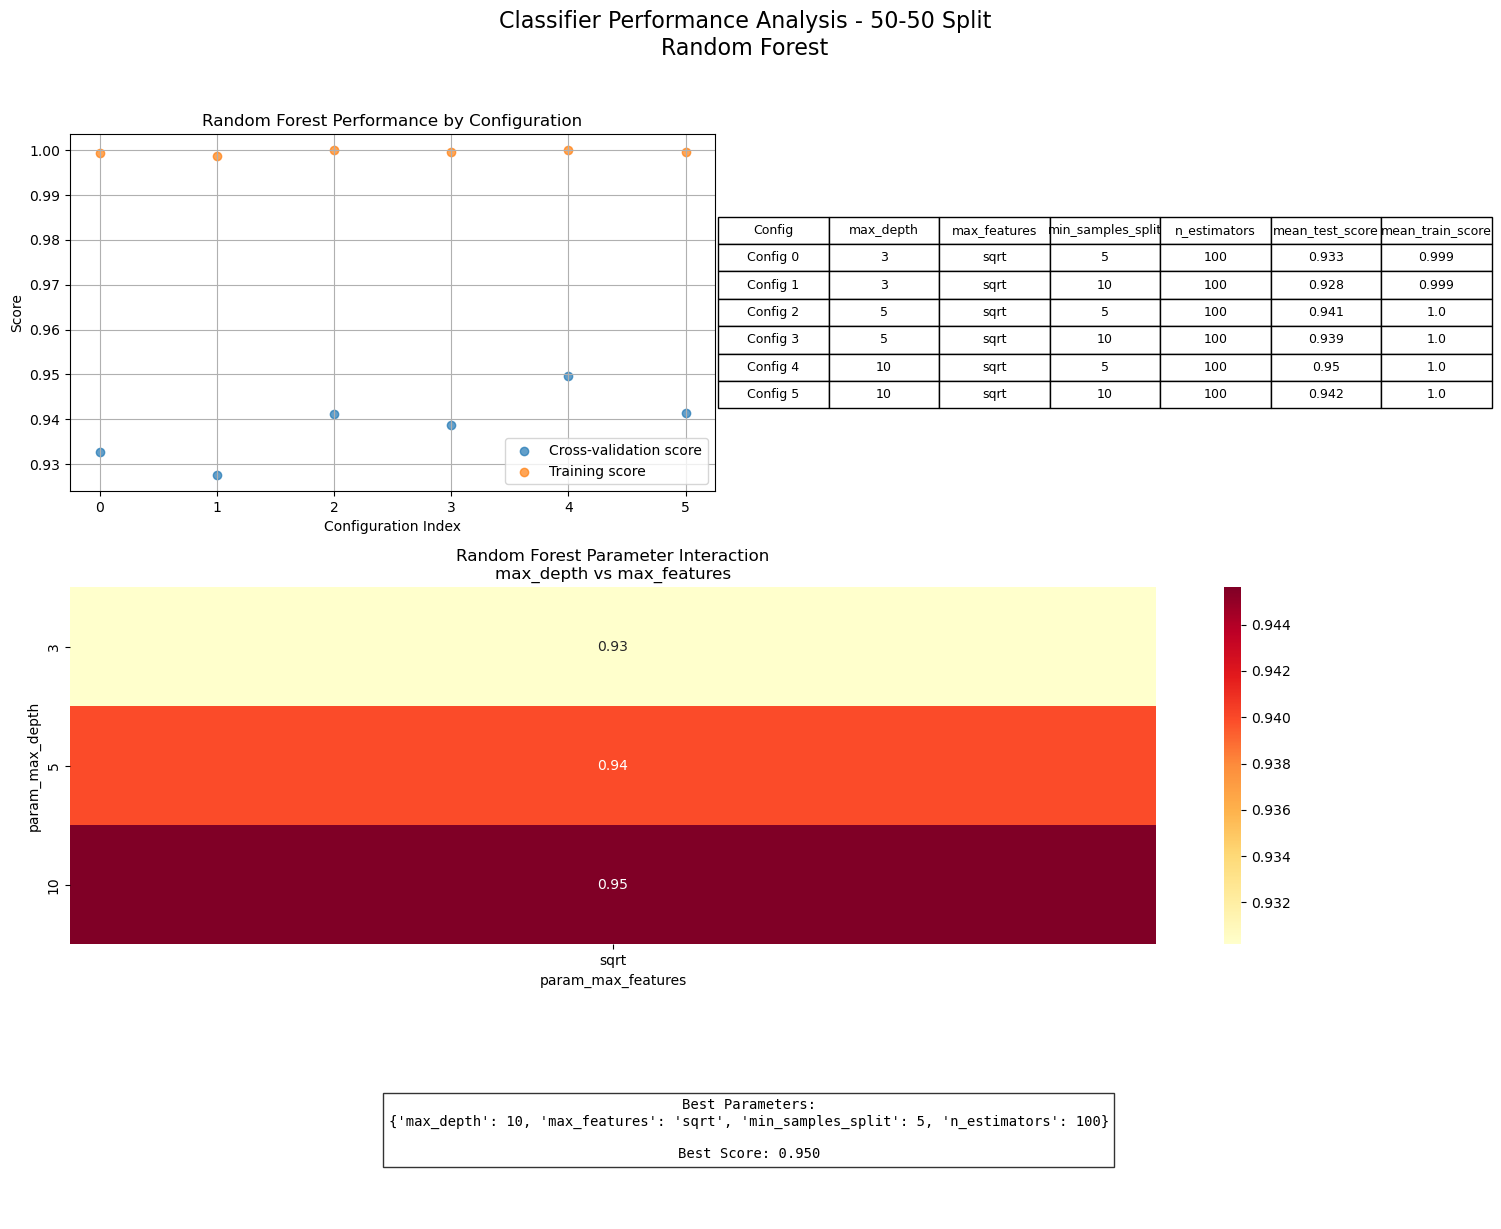

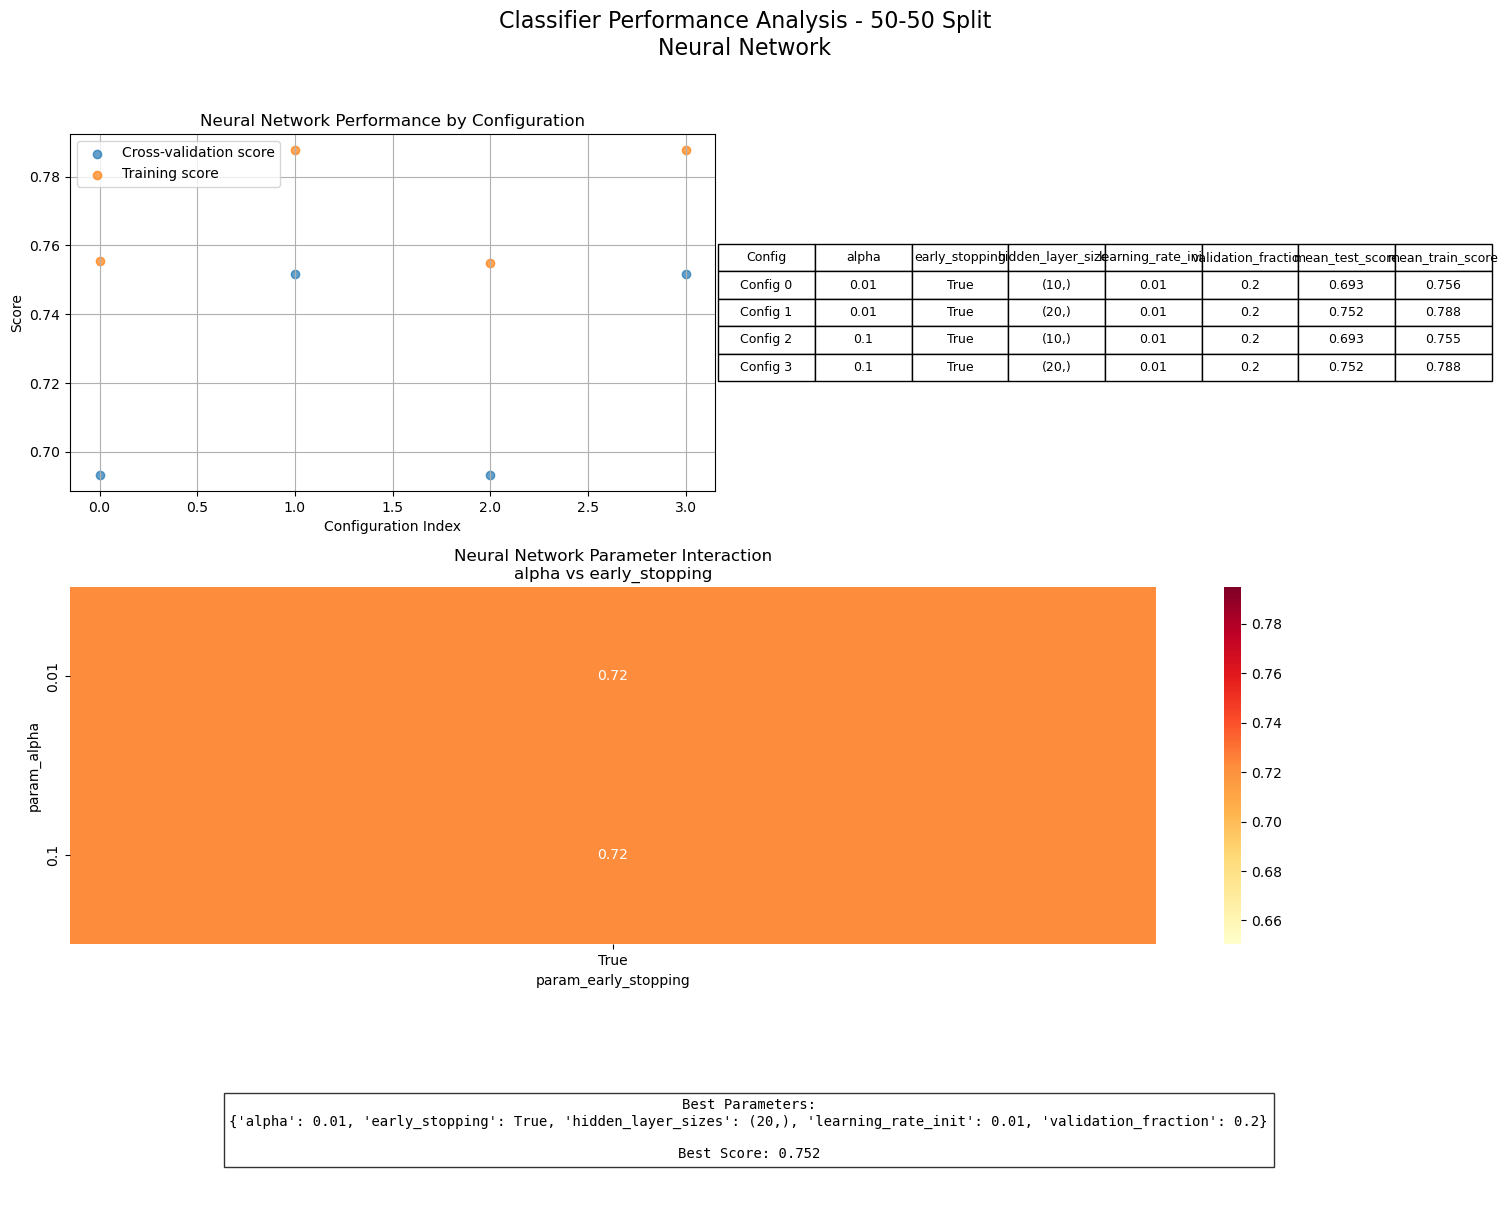

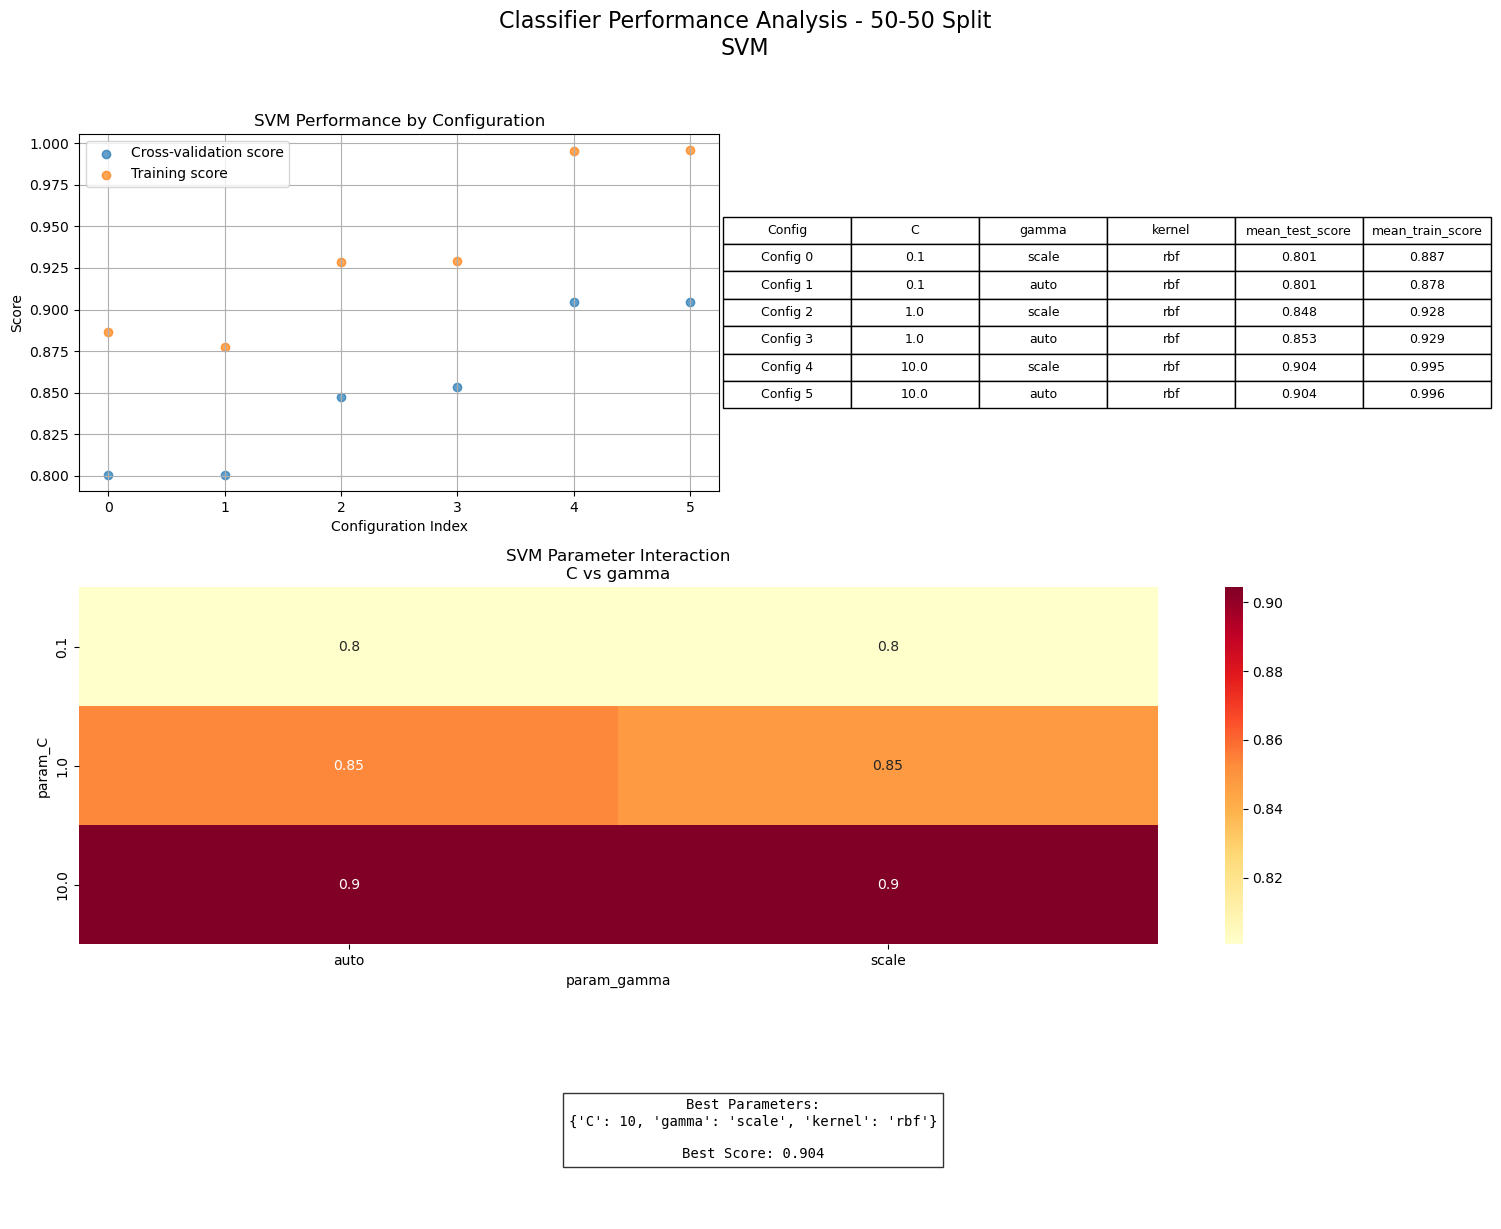


Processing split: 80-20


Trial 1, Split 80-20: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it]


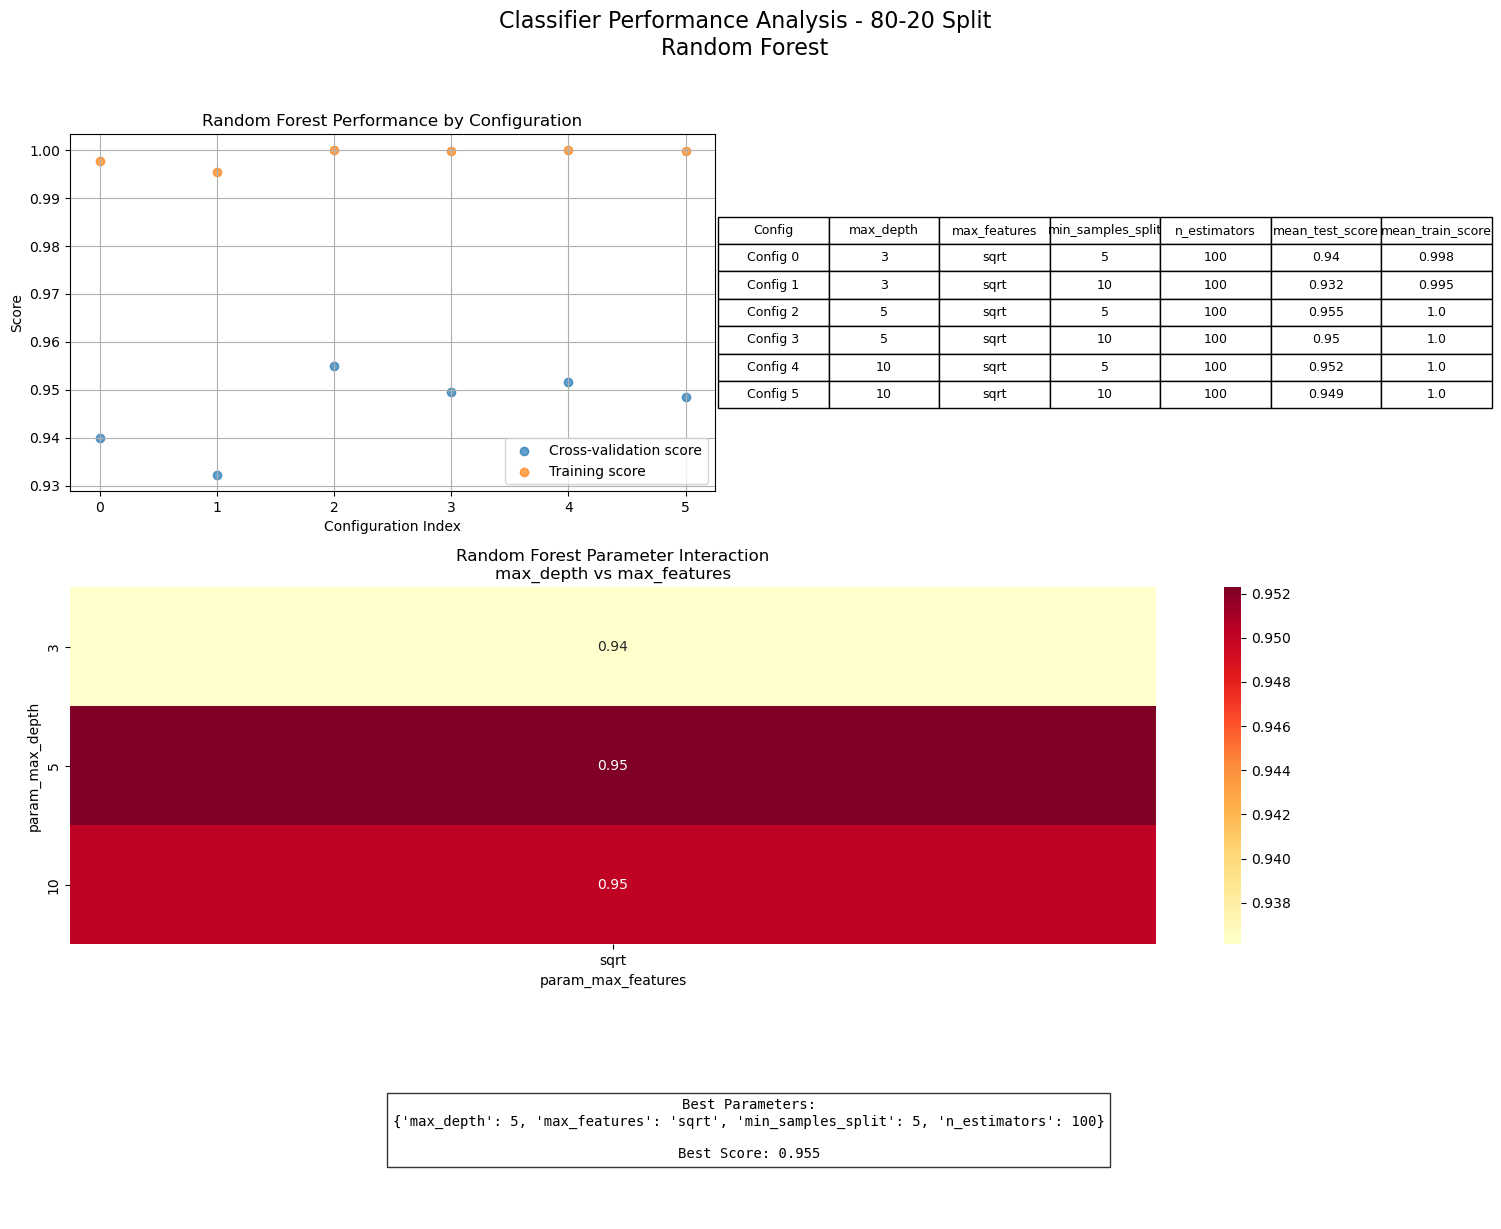

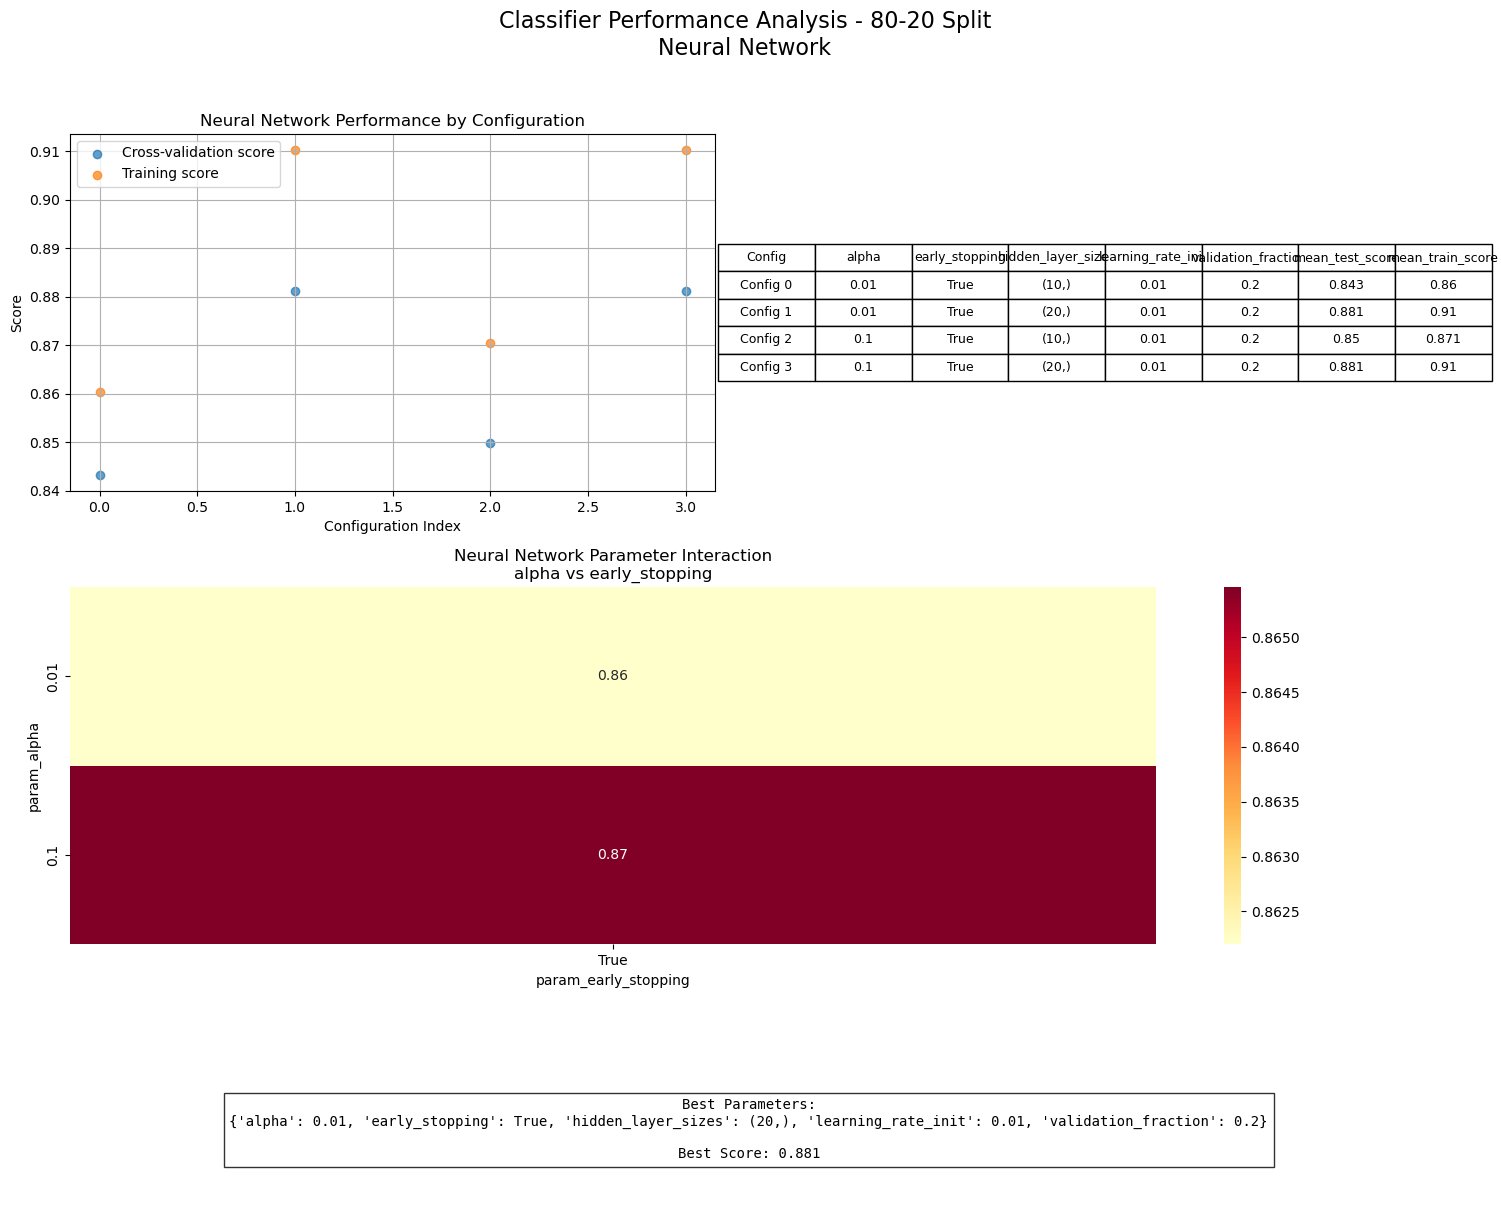

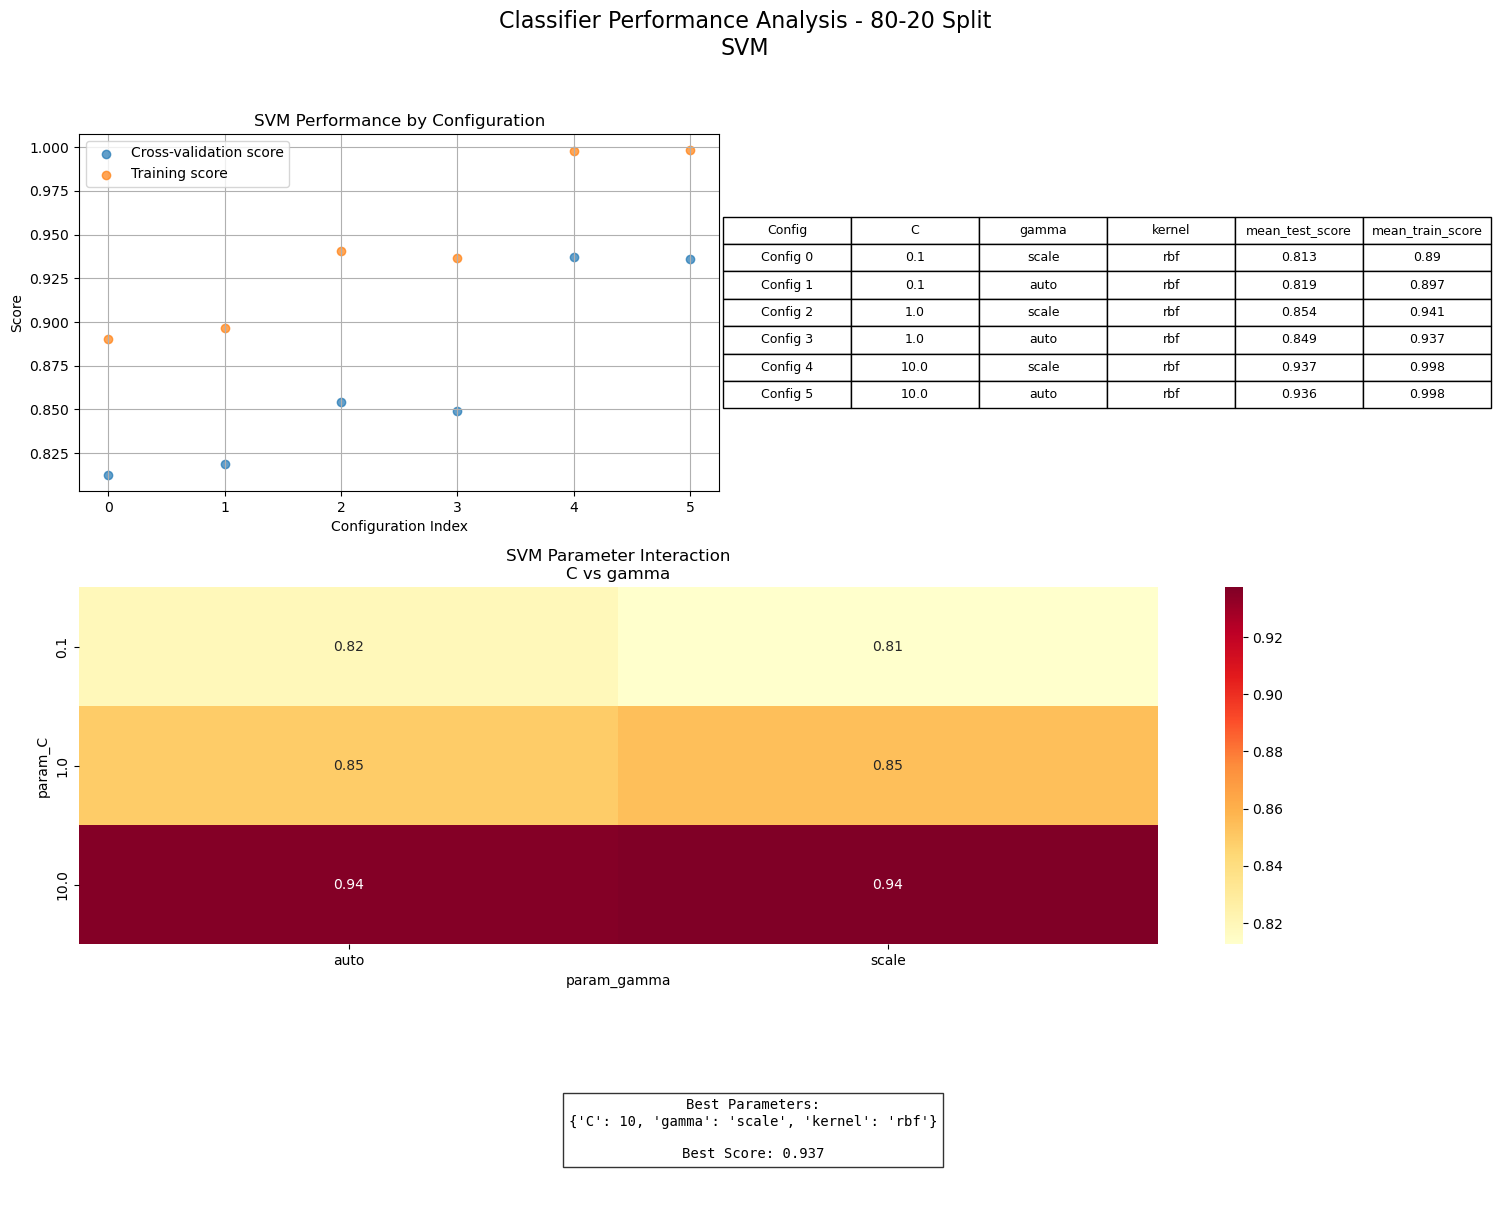


Processing split: 20-80


Trial 2, Split 20-80: 100%|██████████| 3/3 [00:08<00:00,  2.89s/it]


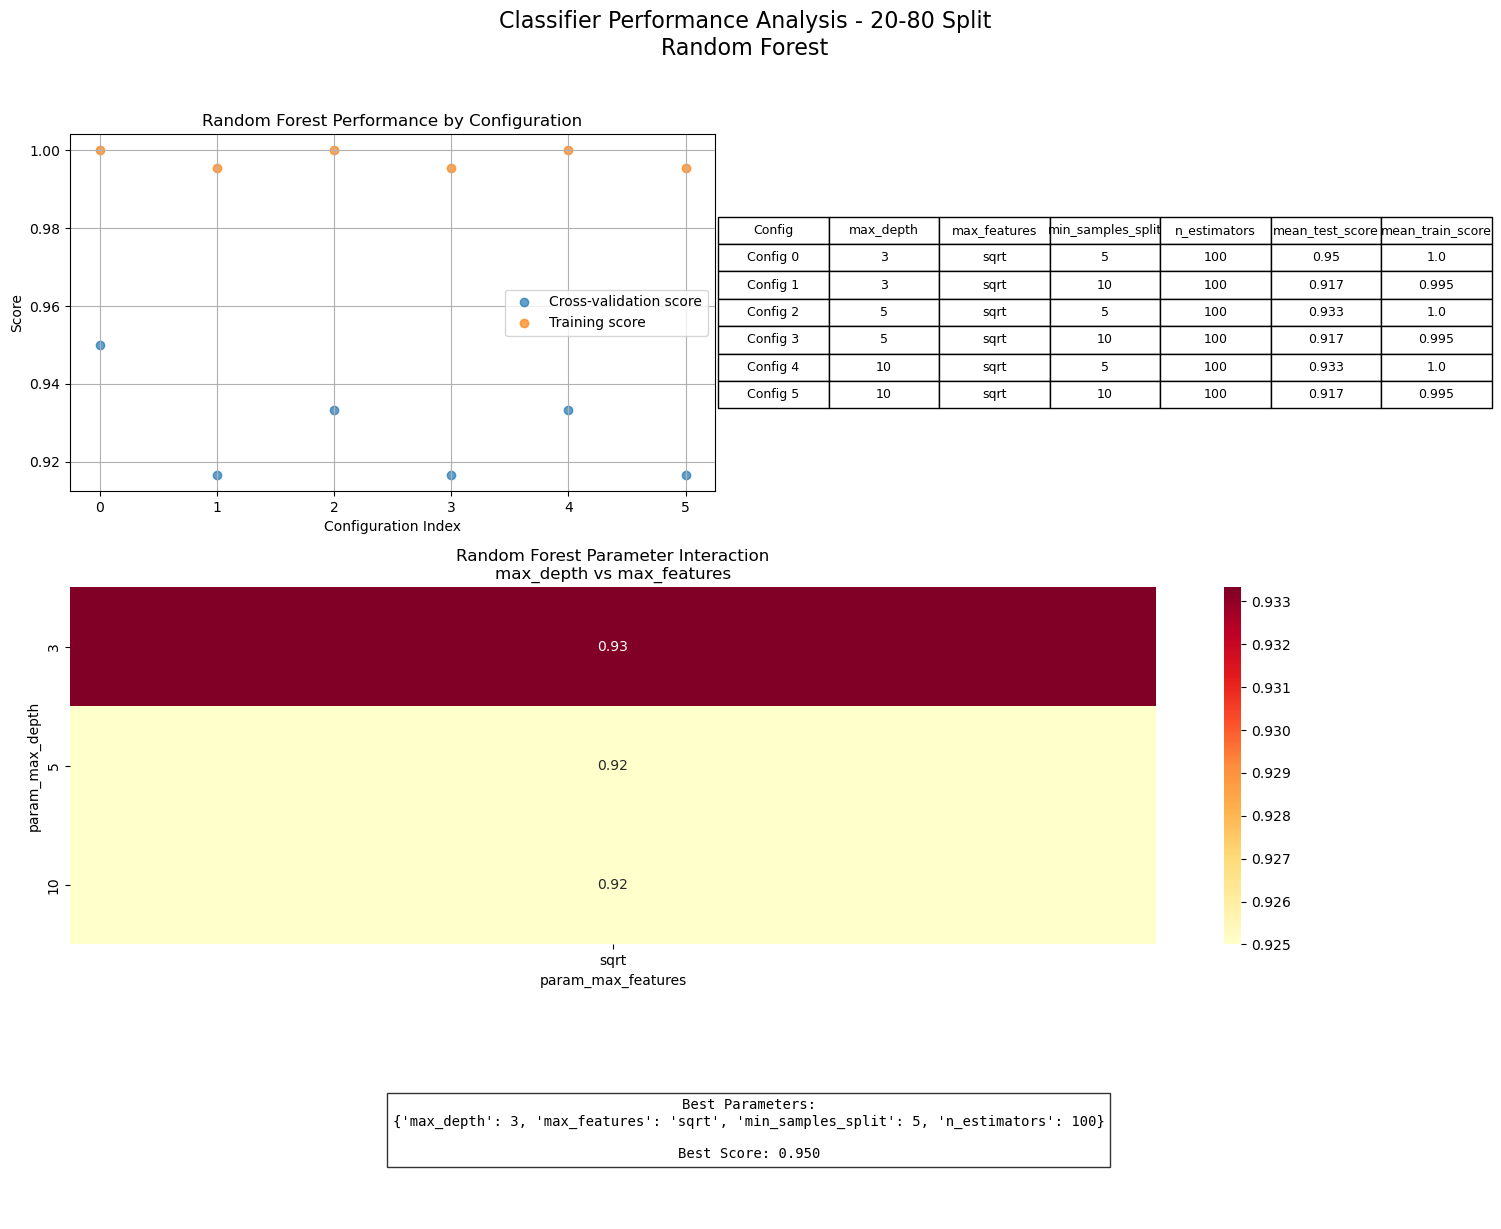

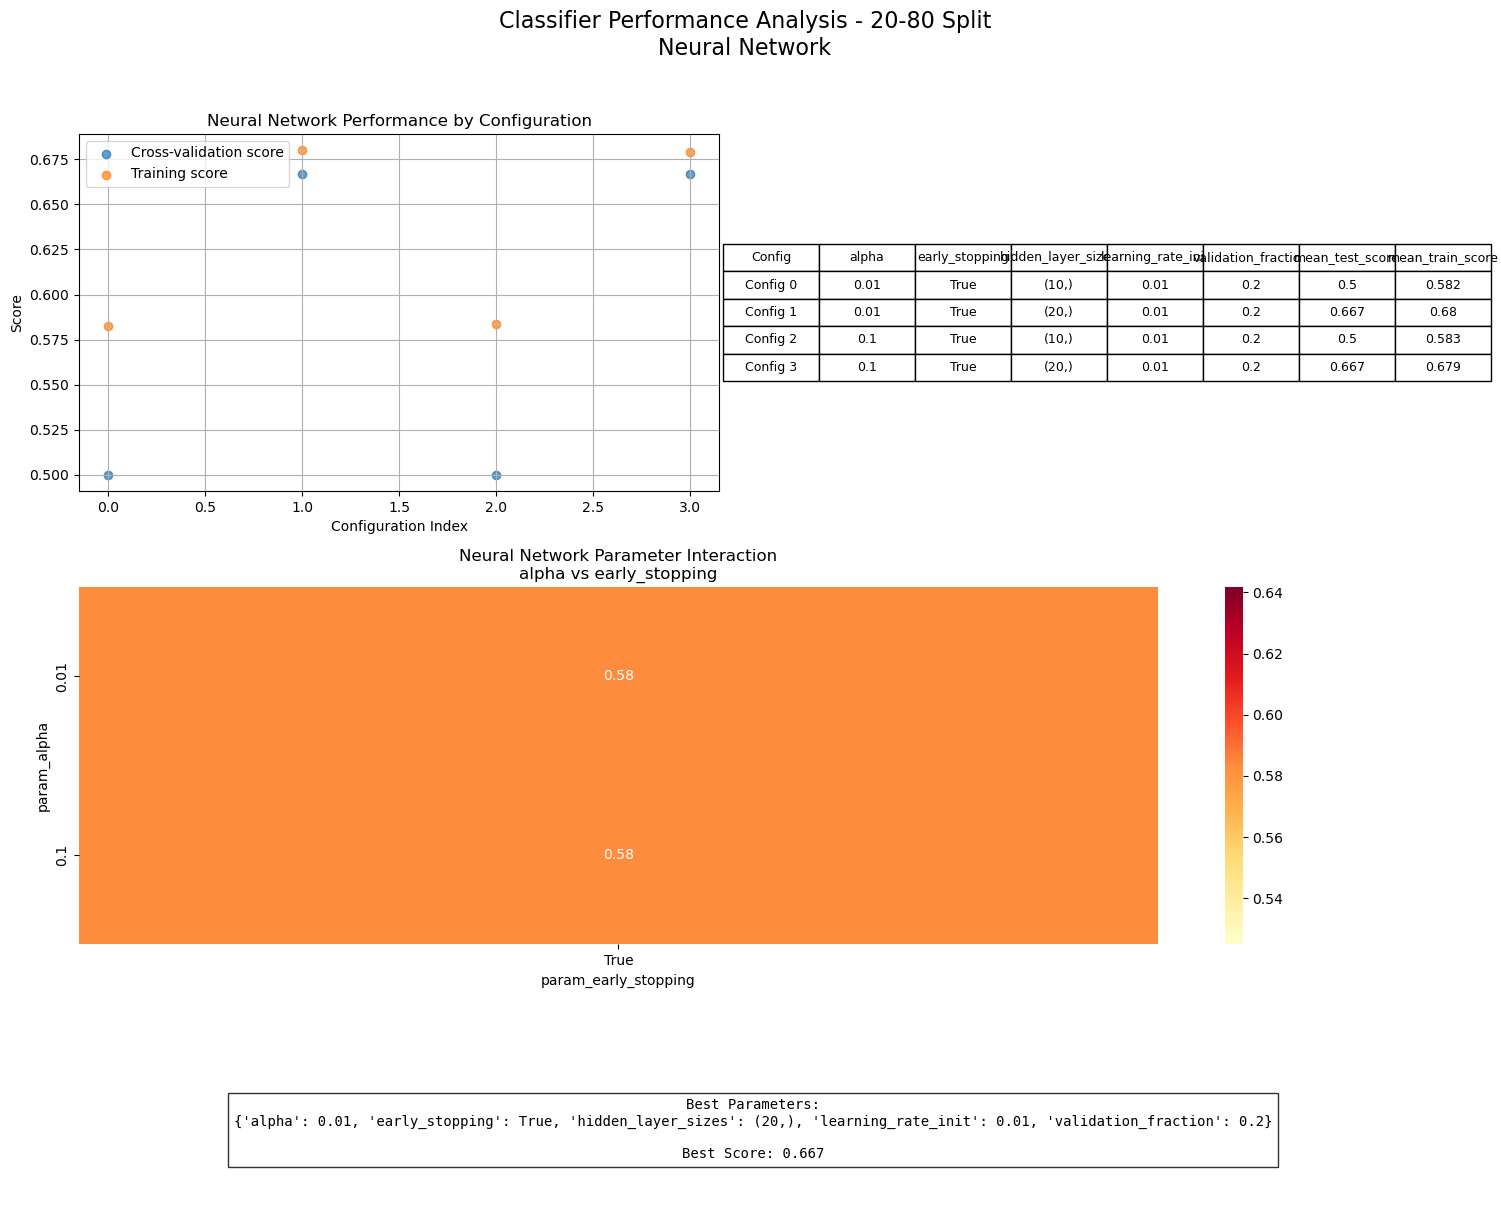

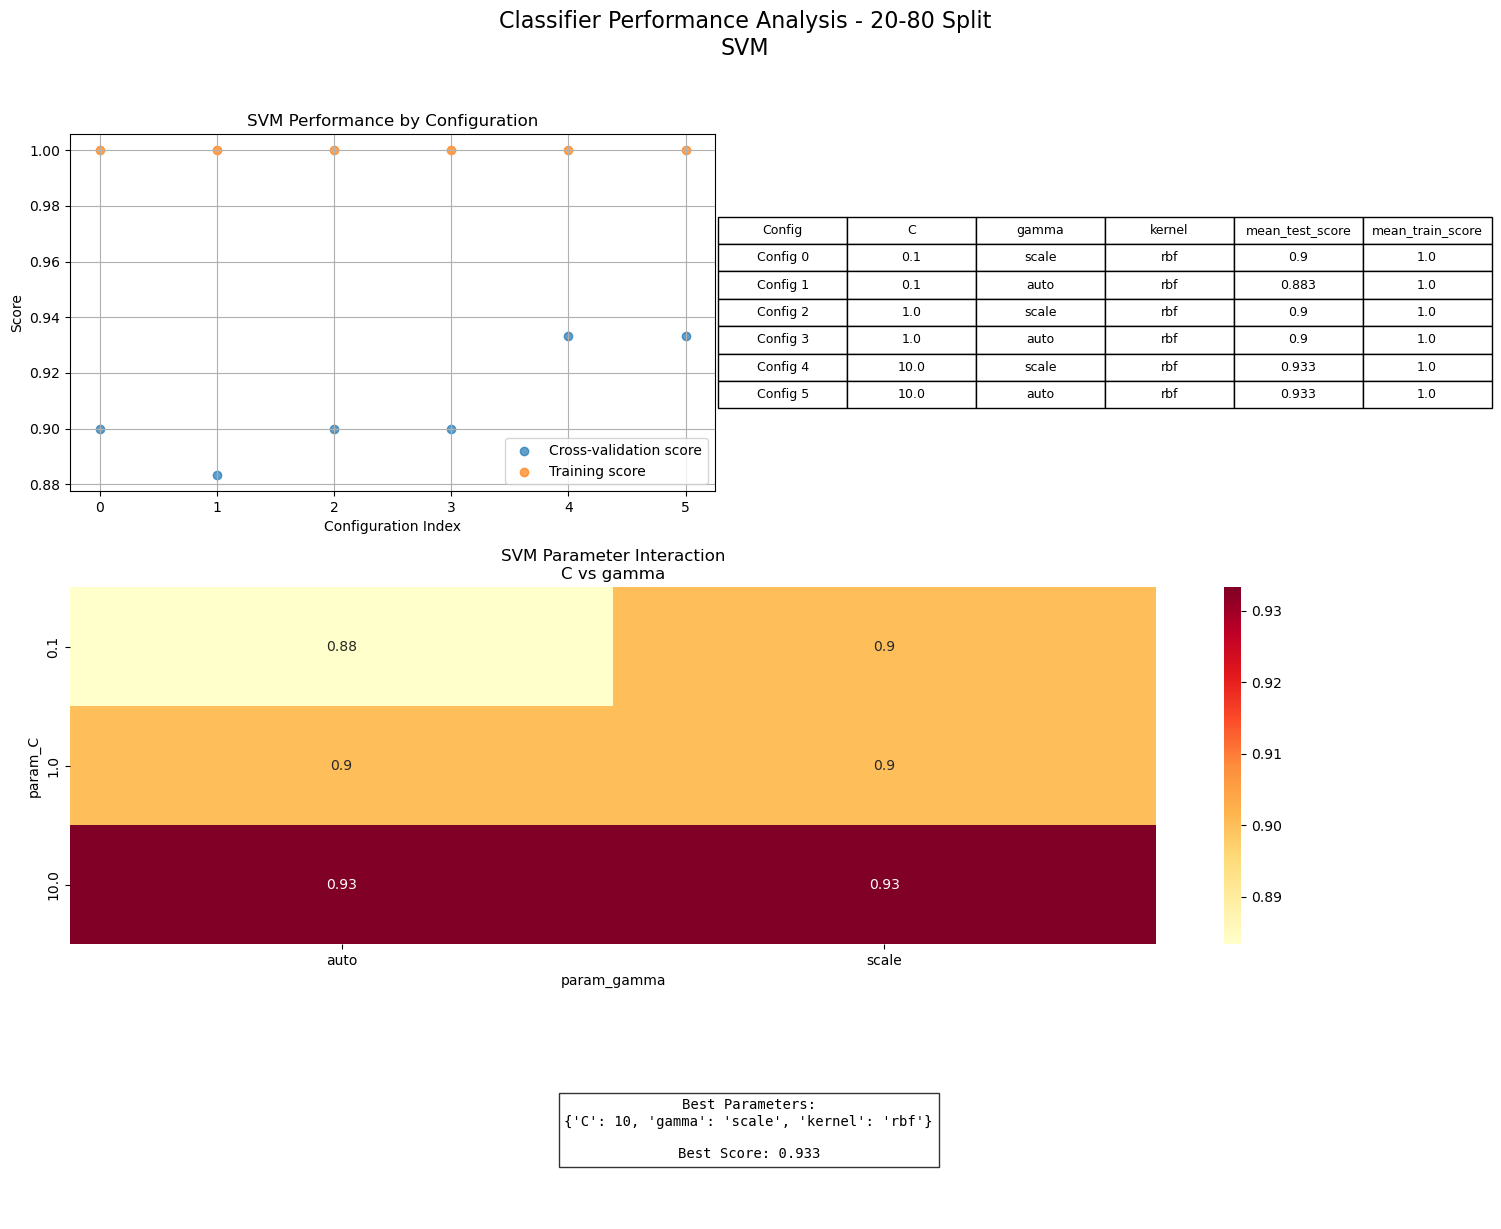


Processing split: 50-50


Trial 2, Split 50-50: 100%|██████████| 3/3 [00:08<00:00,  2.96s/it]


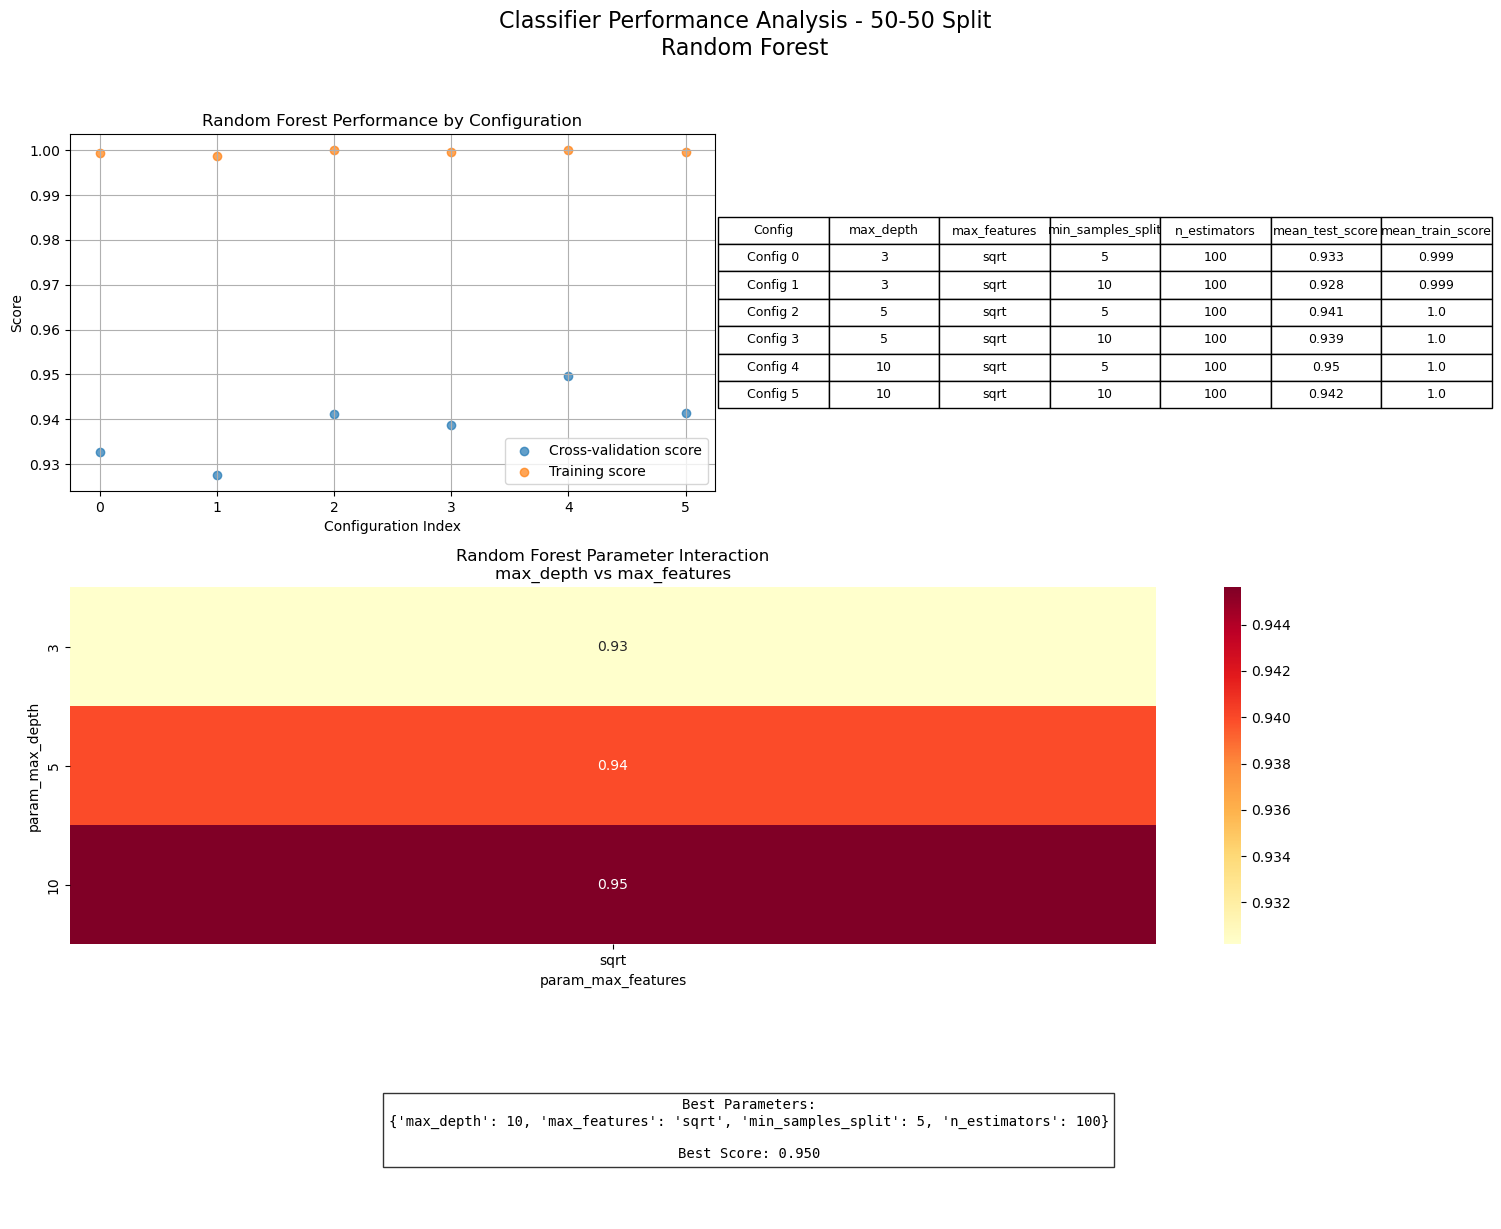

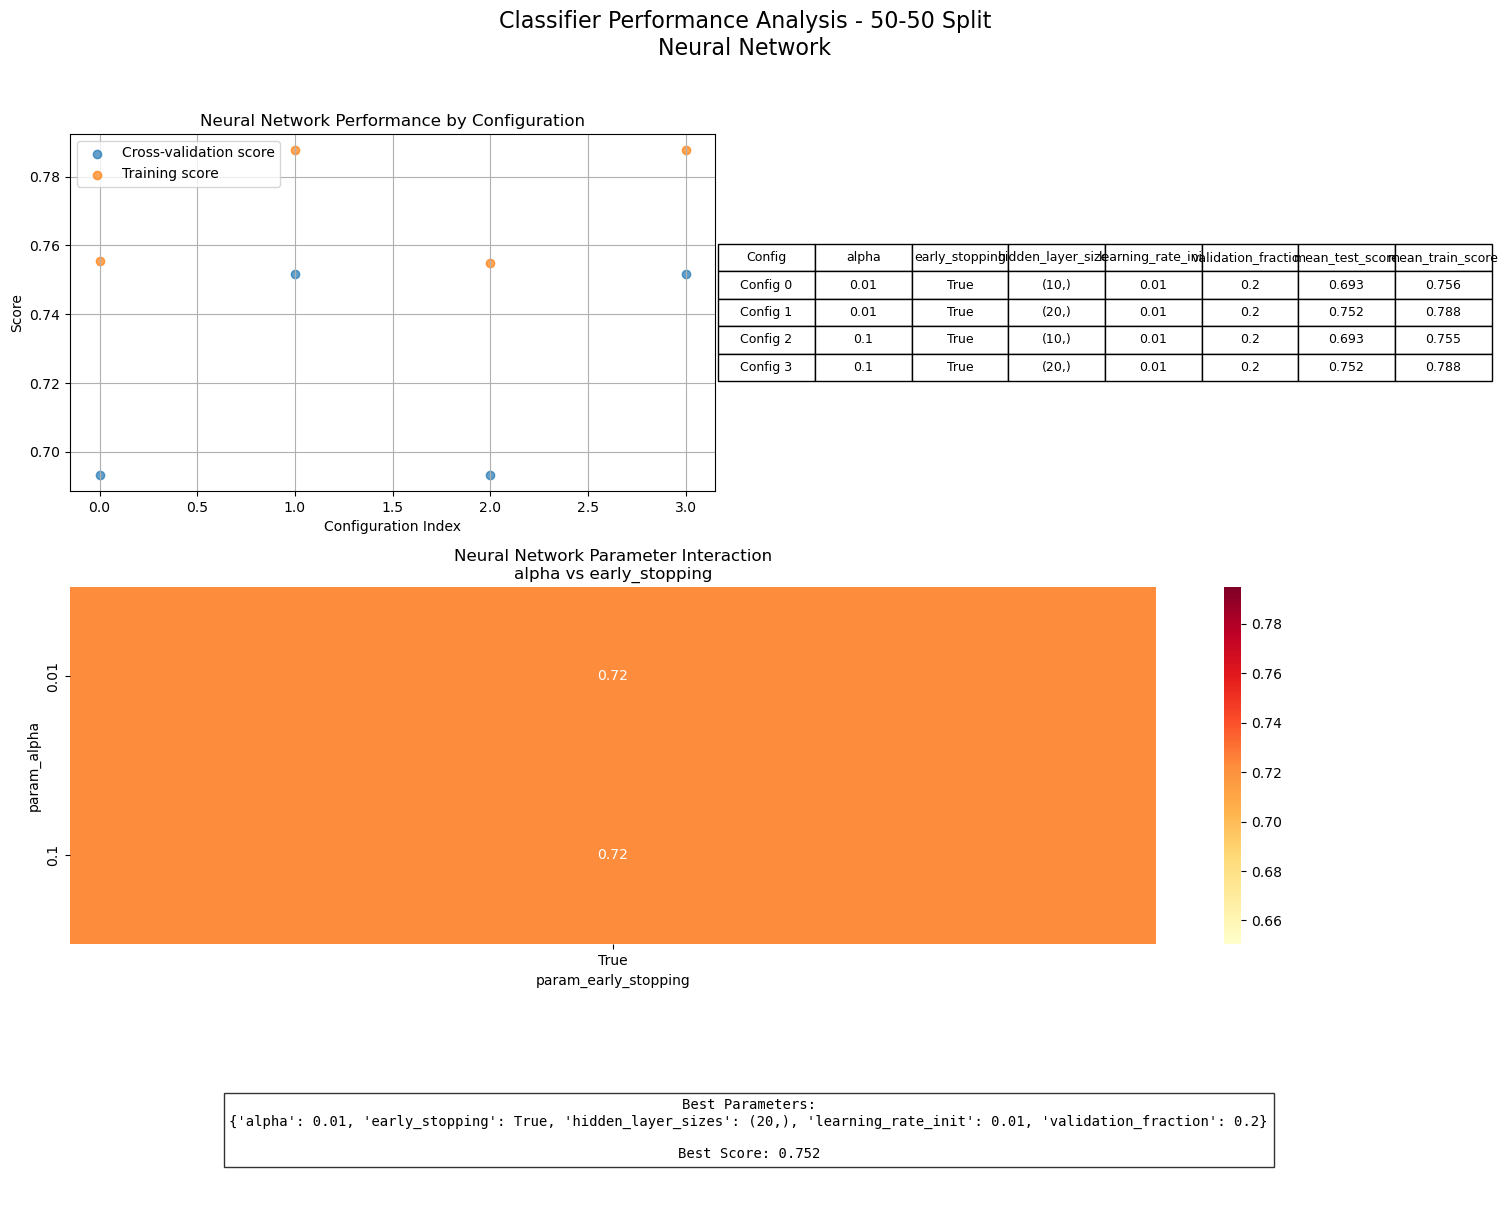

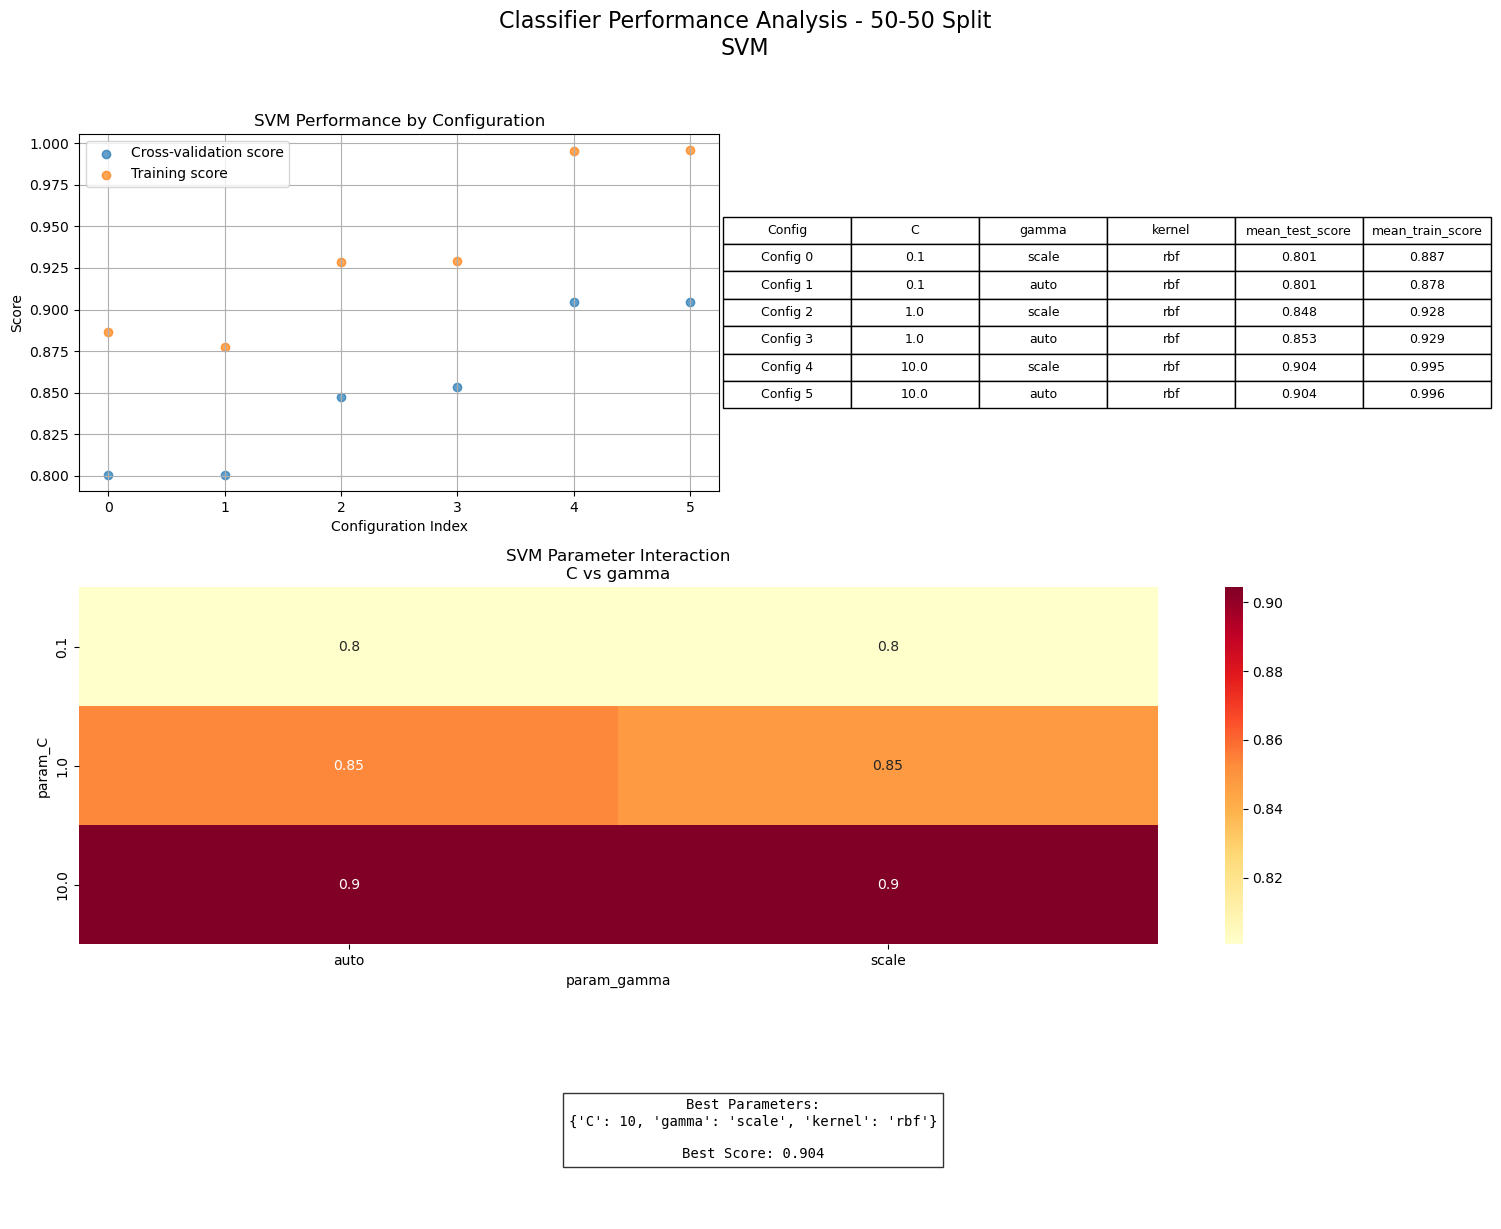


Processing split: 80-20


Trial 2, Split 80-20: 100%|██████████| 3/3 [00:07<00:00,  2.61s/it]


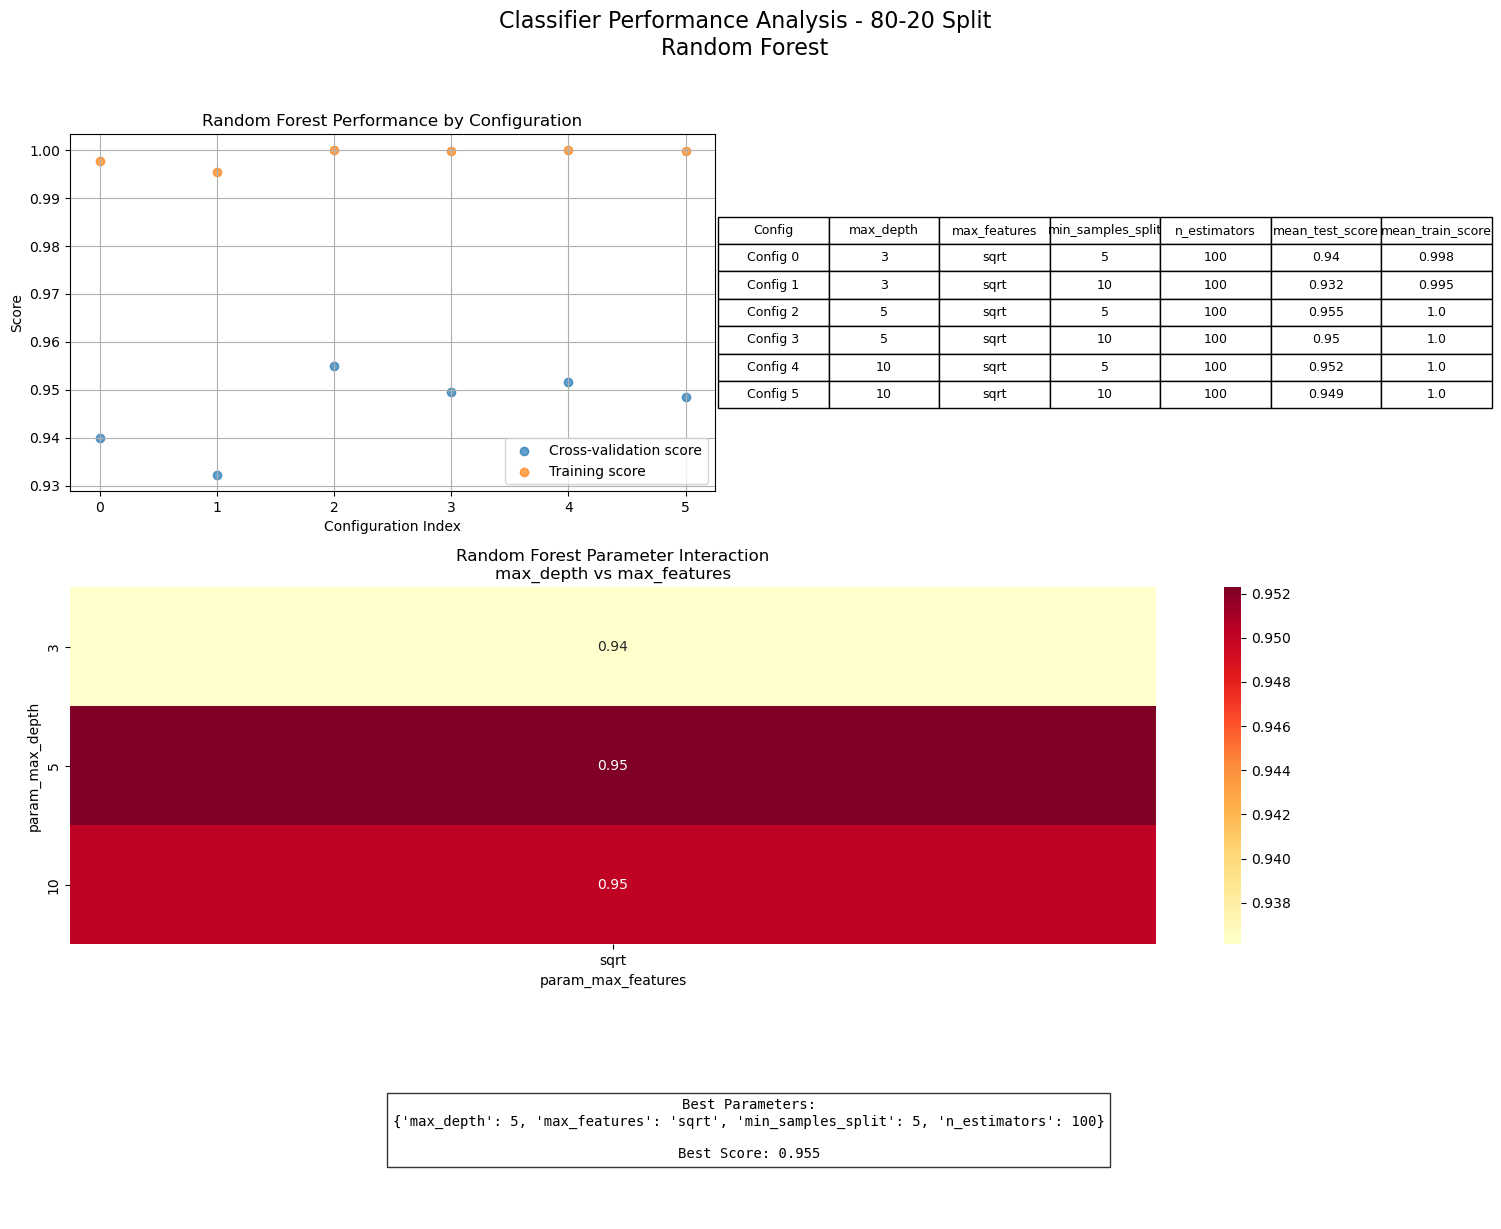

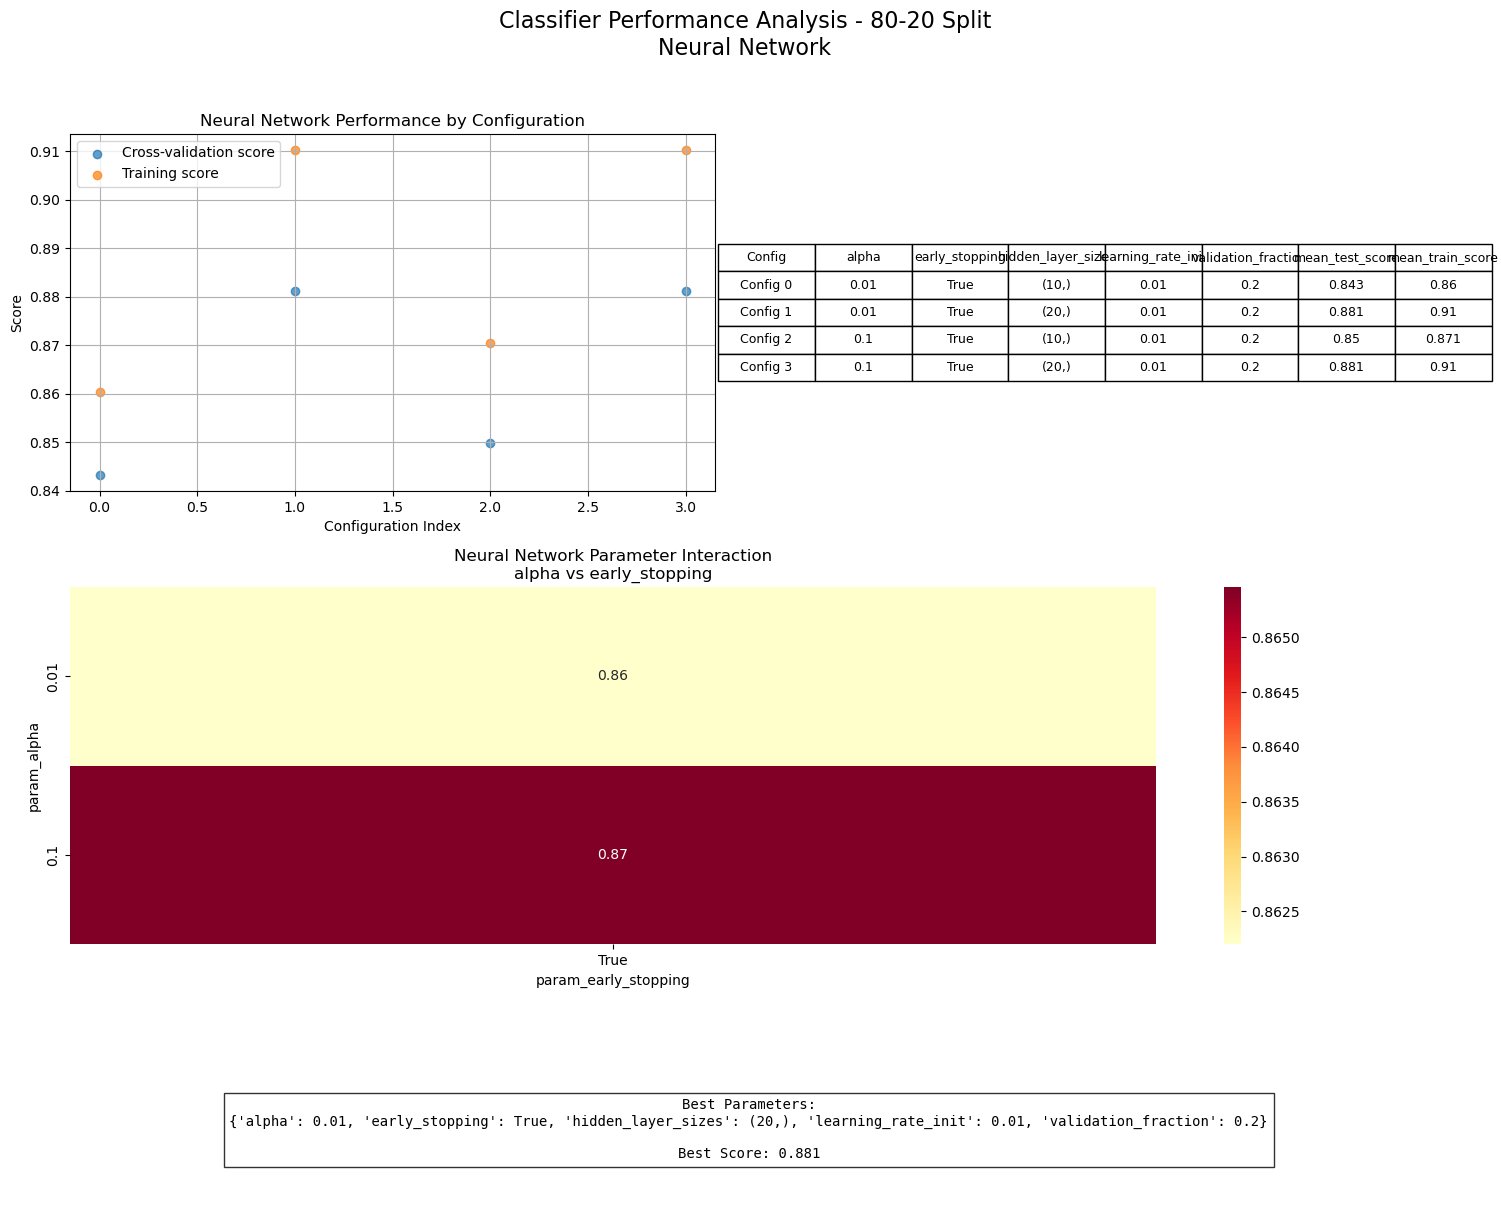

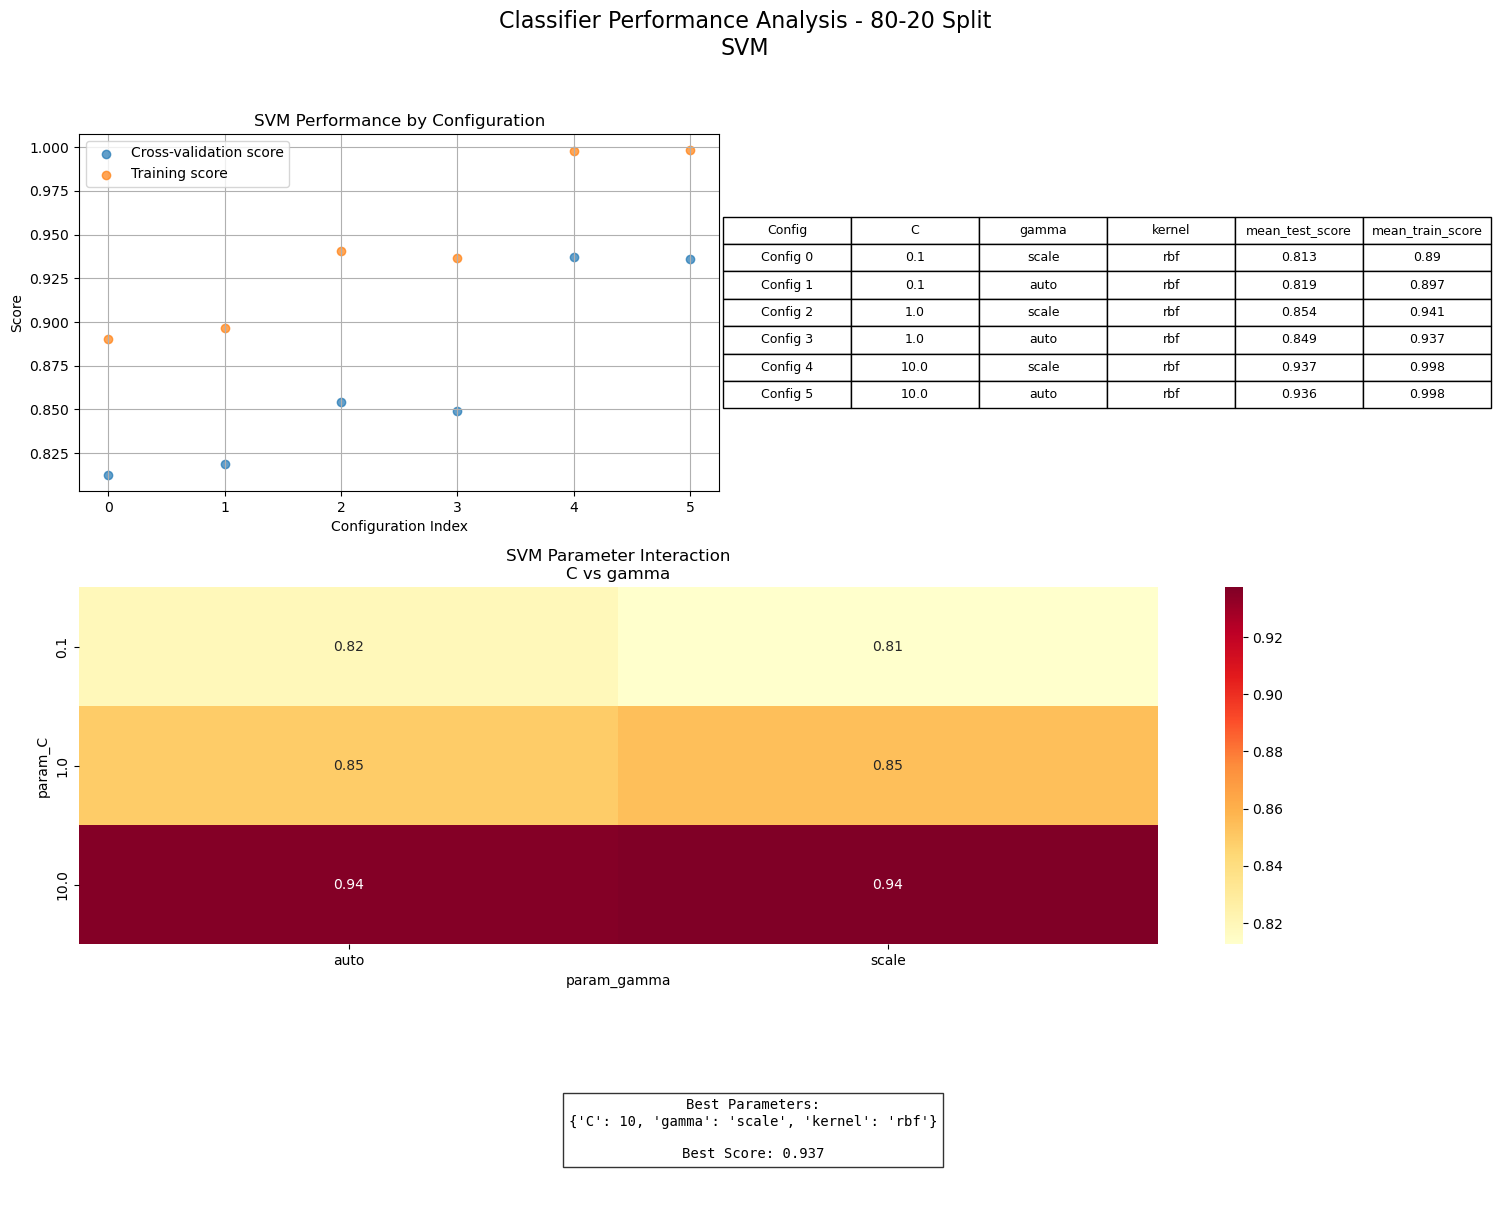


Processing split: 20-80


Trial 3, Split 20-80: 100%|██████████| 3/3 [00:07<00:00,  2.65s/it]


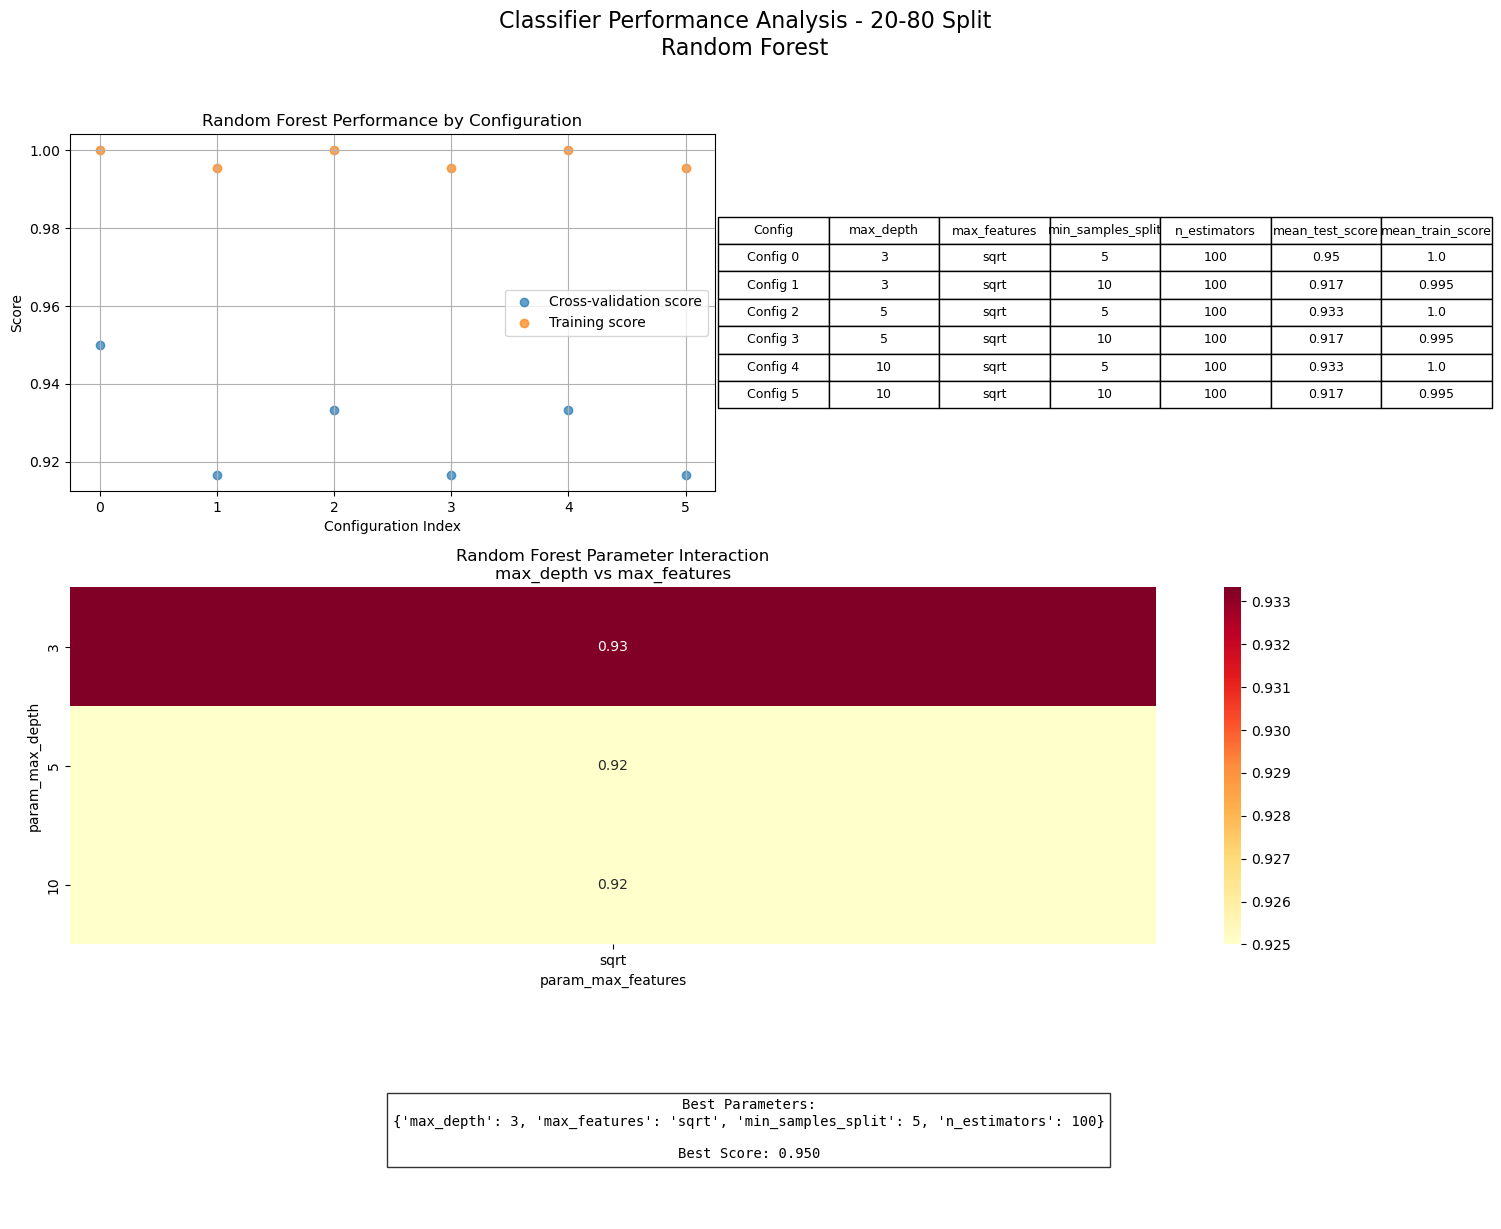

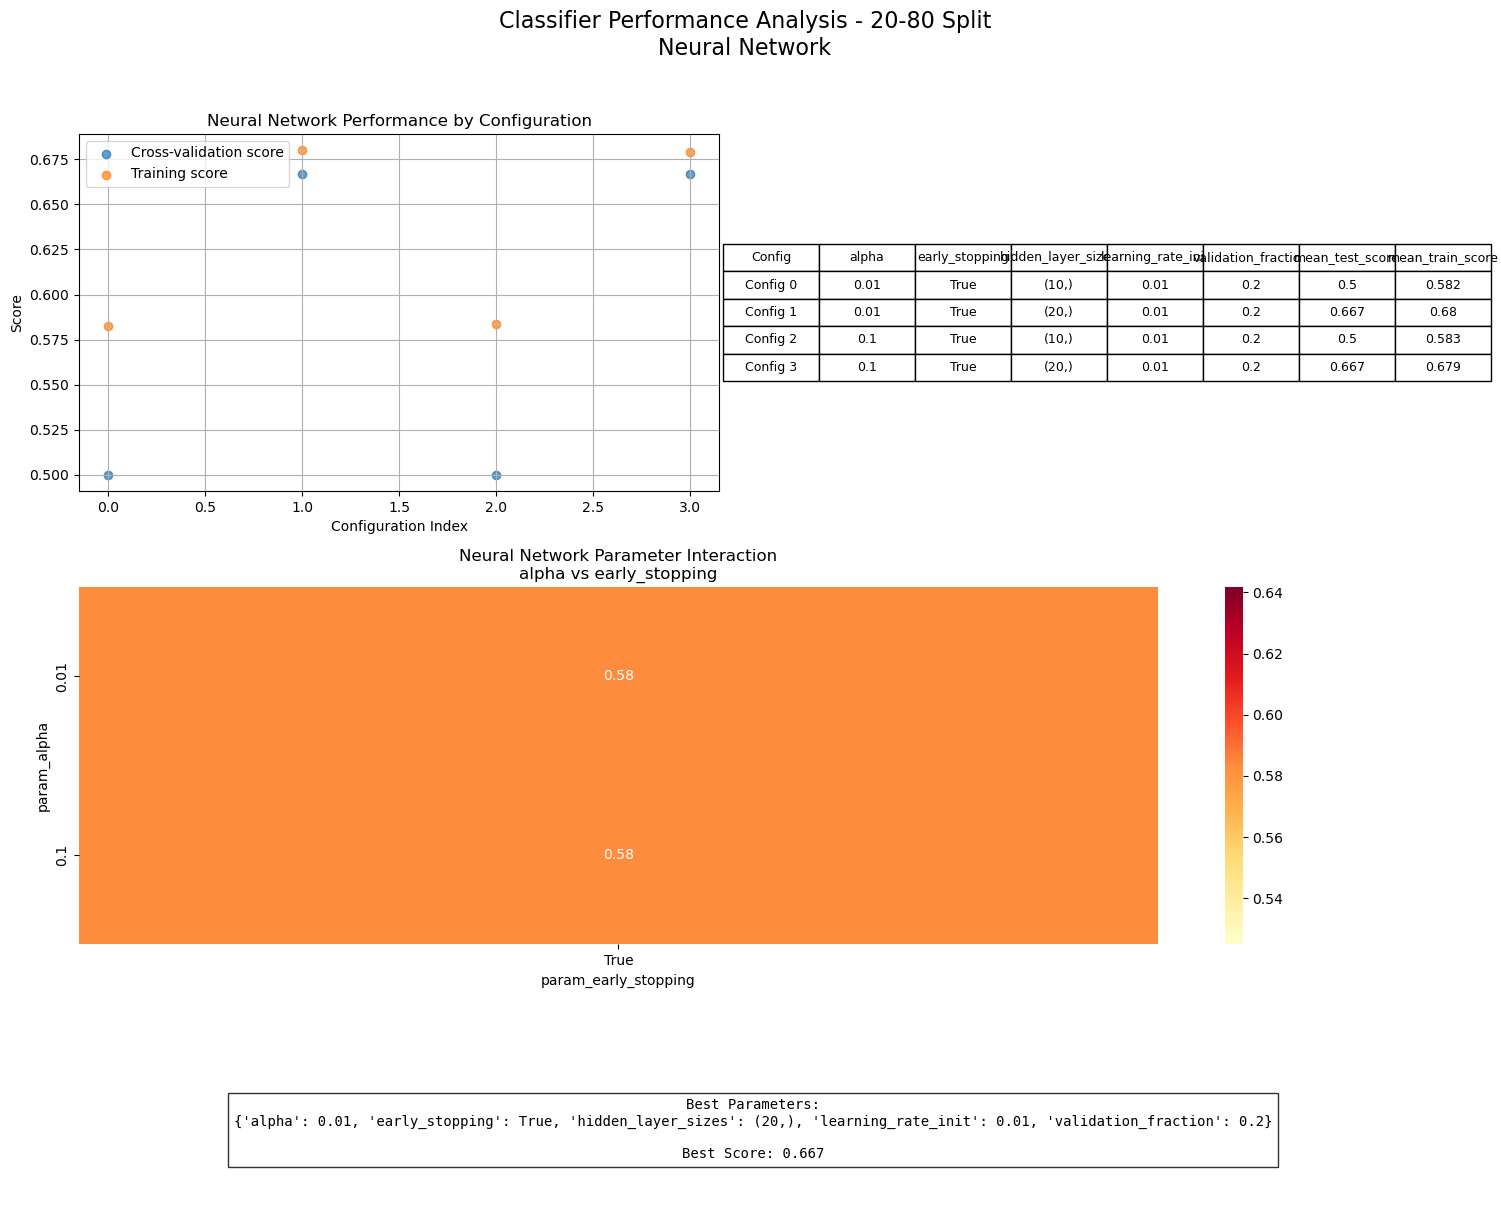

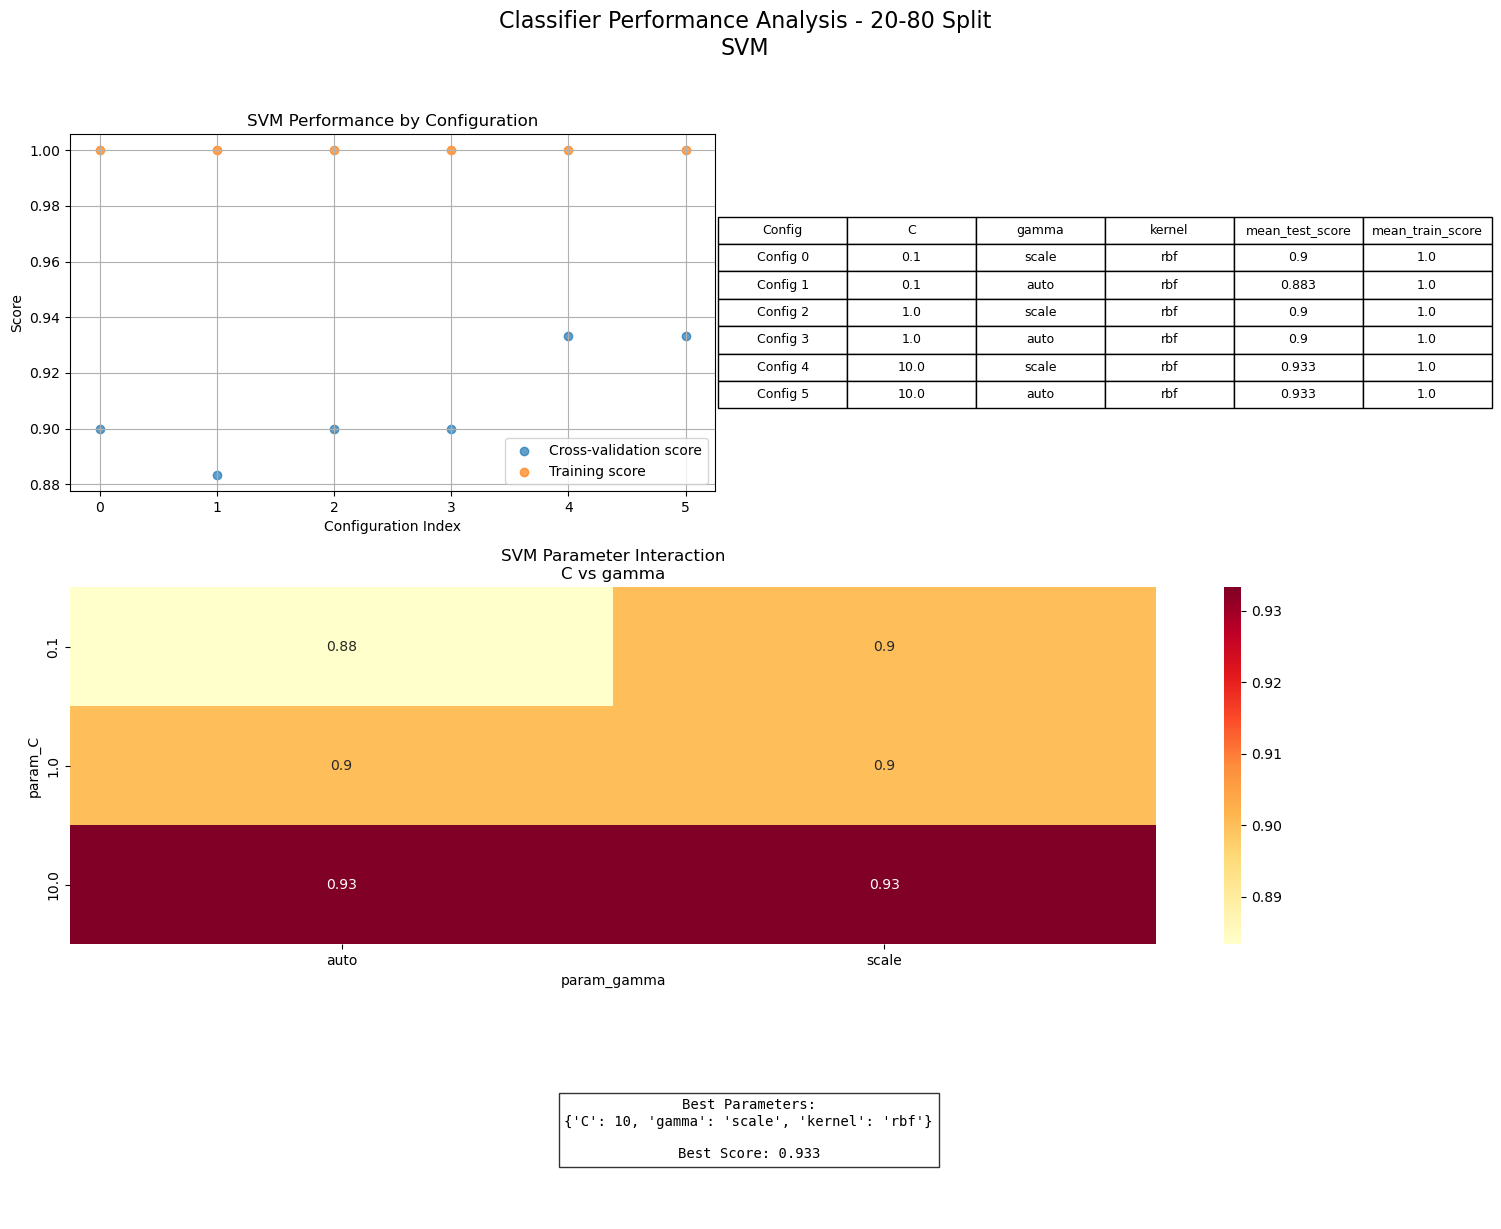


Processing split: 50-50


Trial 3, Split 50-50: 100%|██████████| 3/3 [00:06<00:00,  2.28s/it]


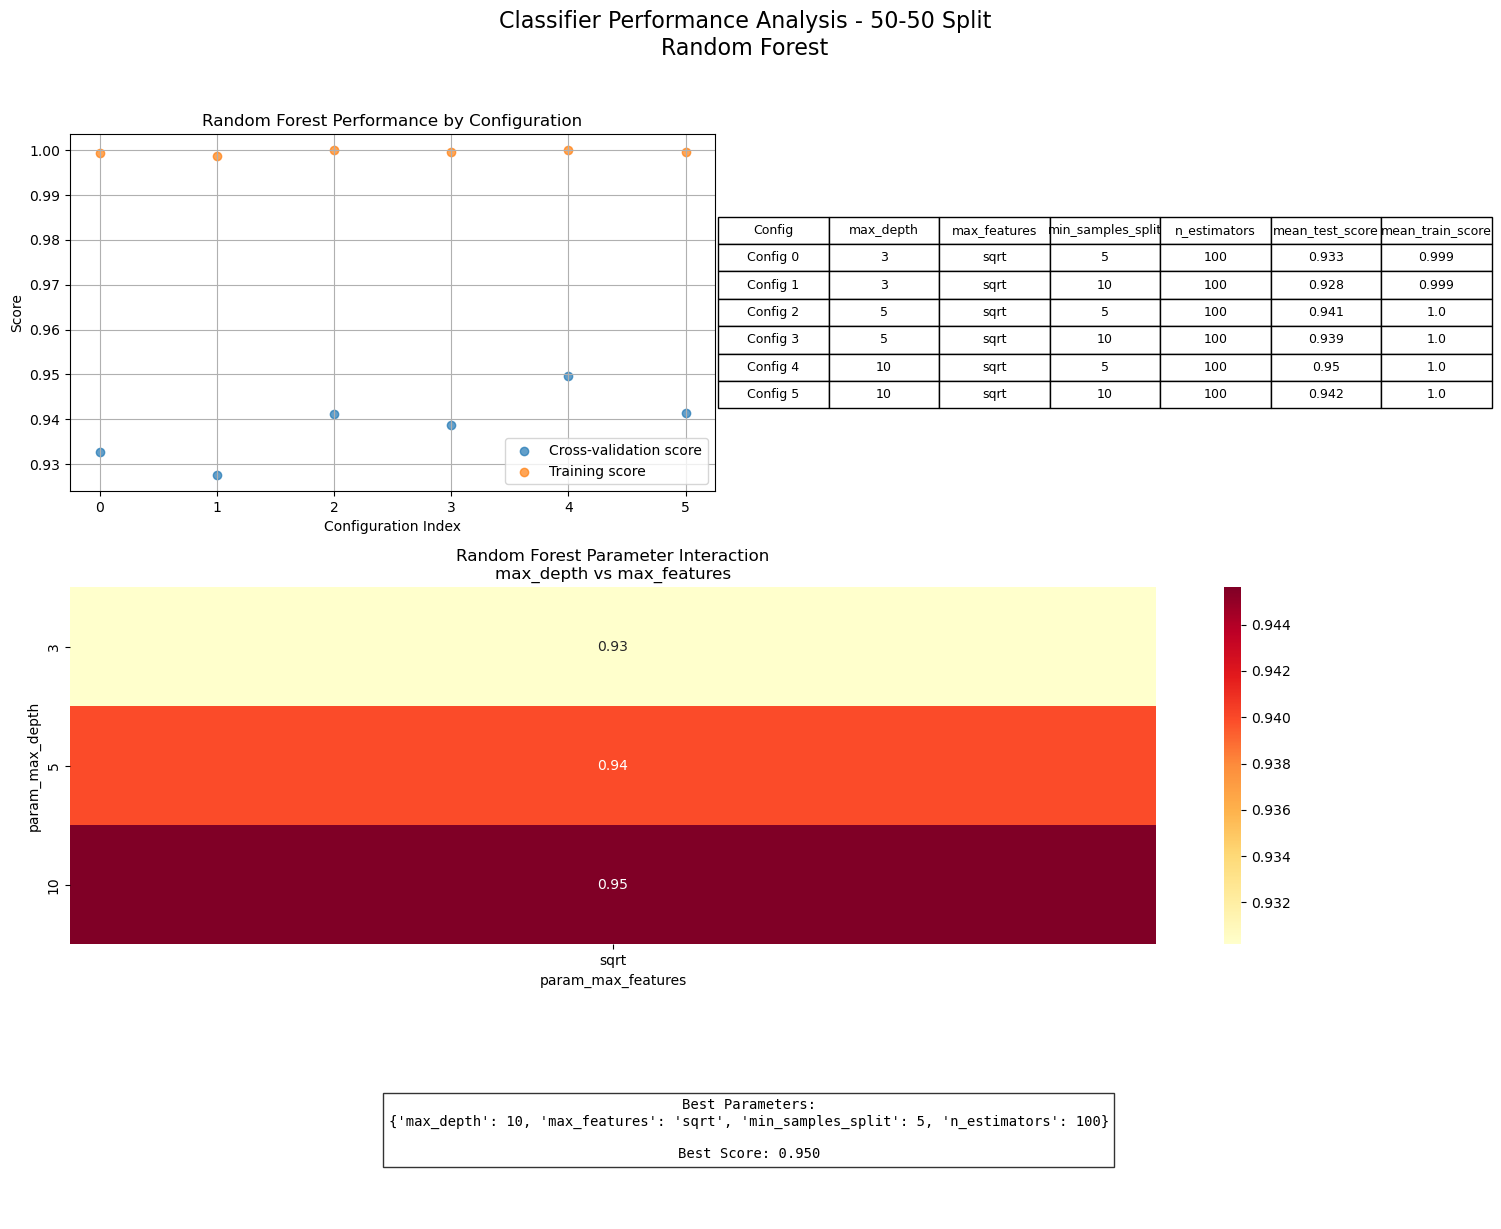

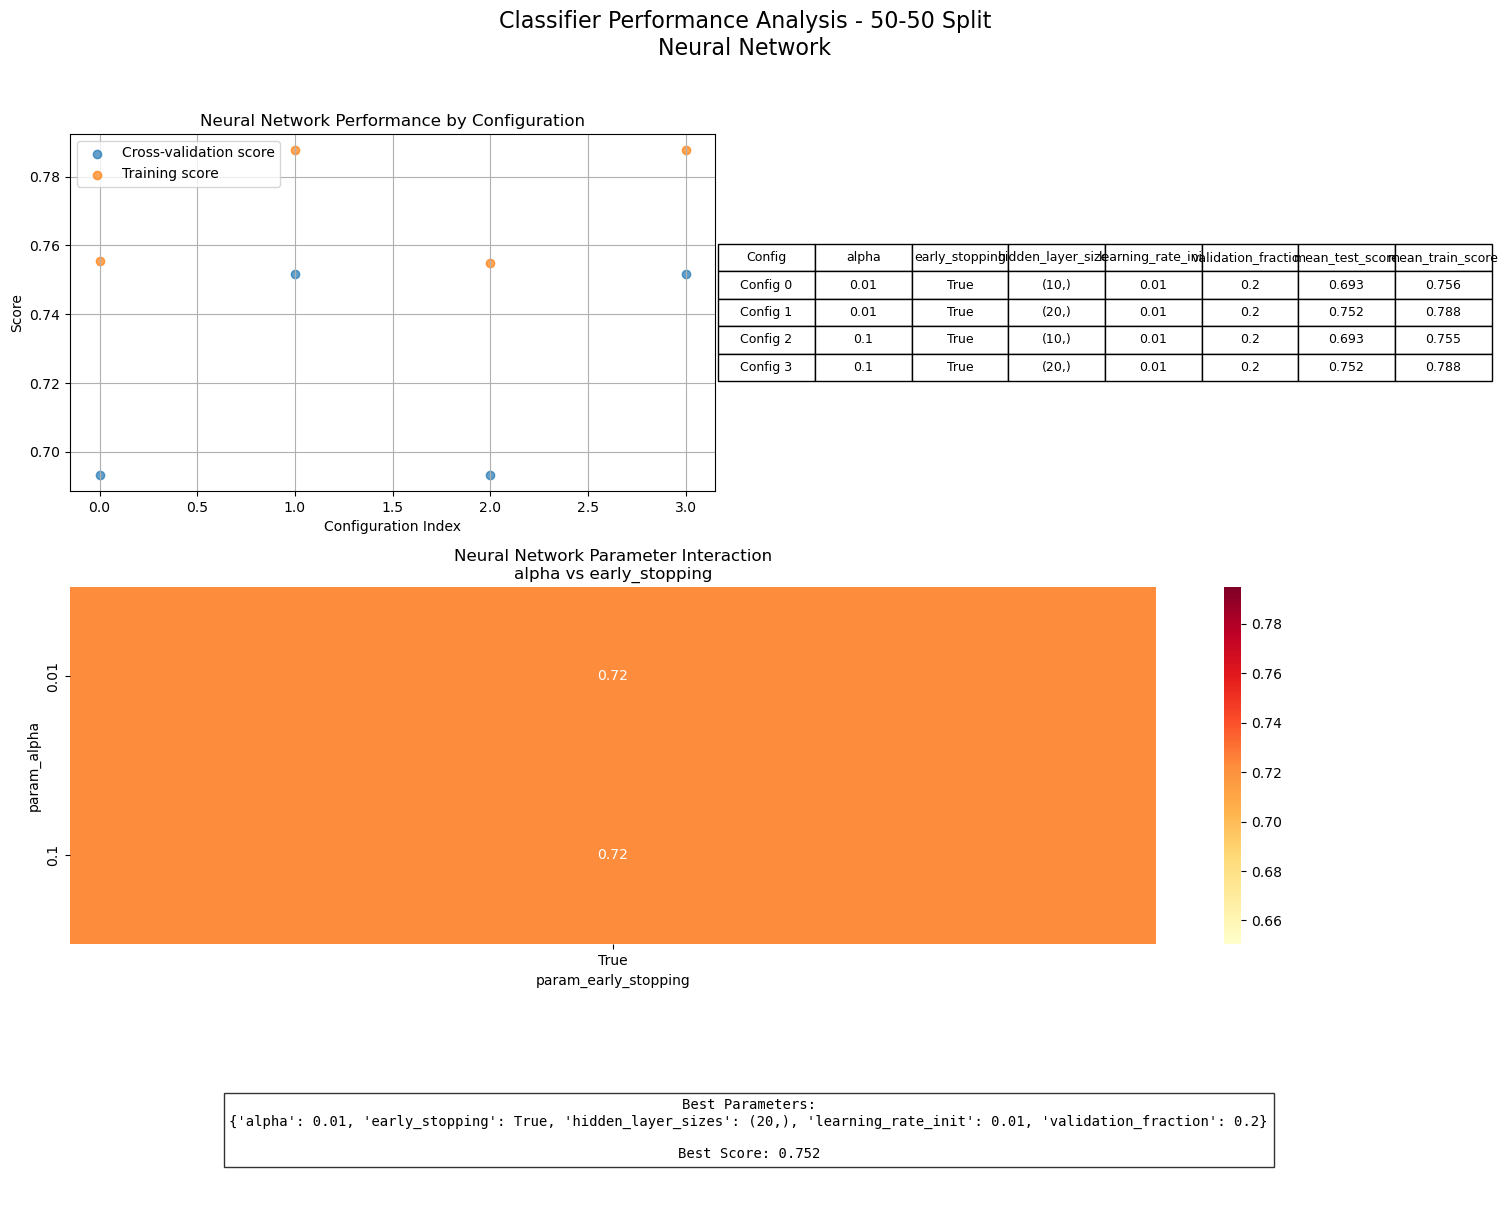

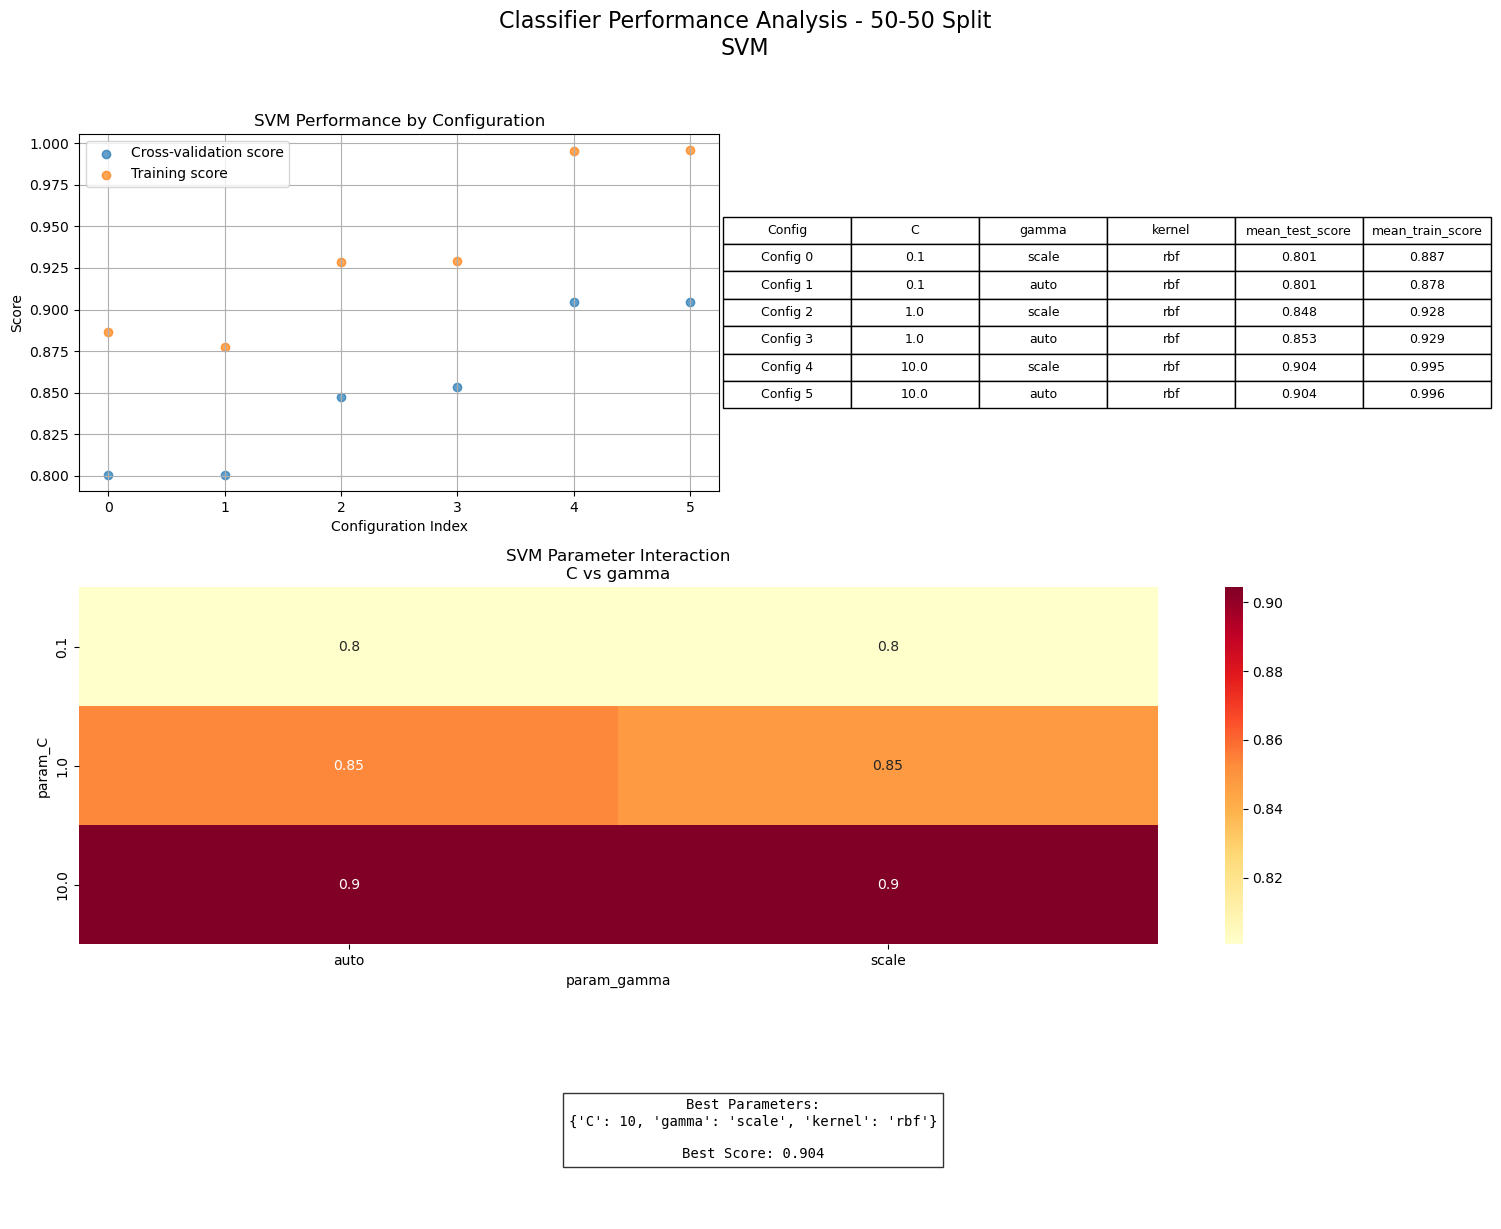


Processing split: 80-20


Trial 3, Split 80-20: 100%|██████████| 3/3 [00:06<00:00,  2.12s/it]


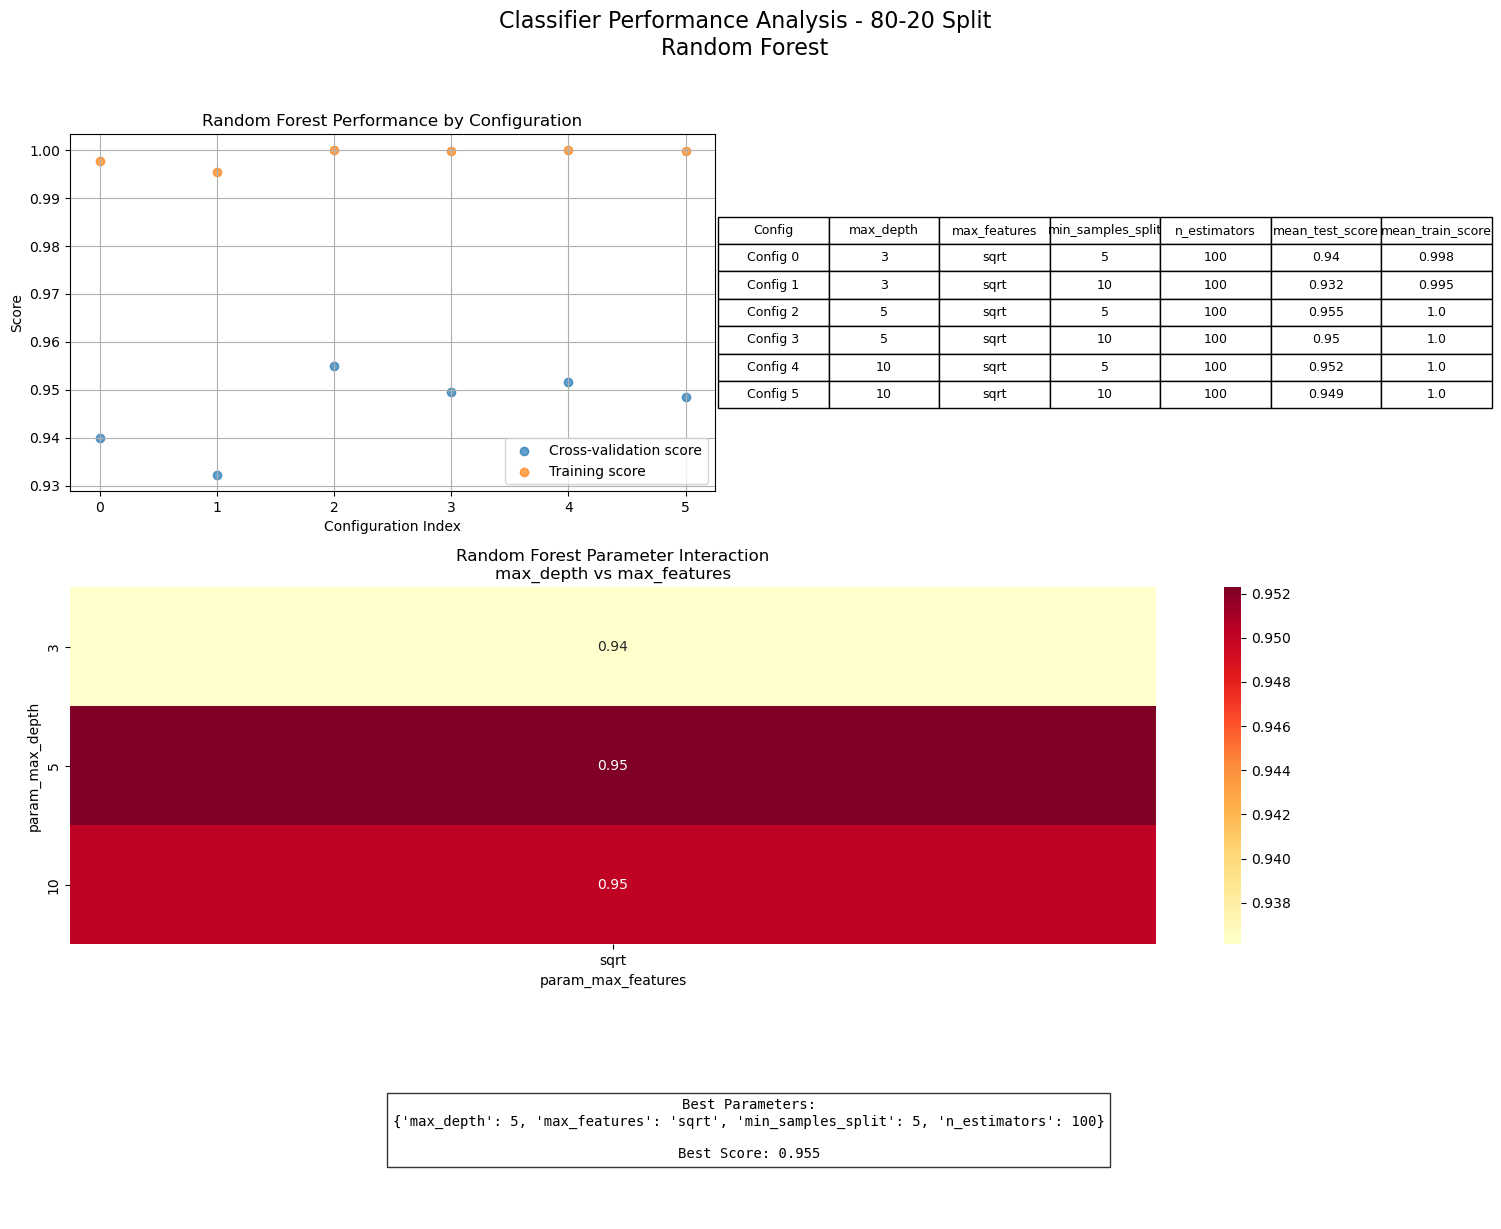

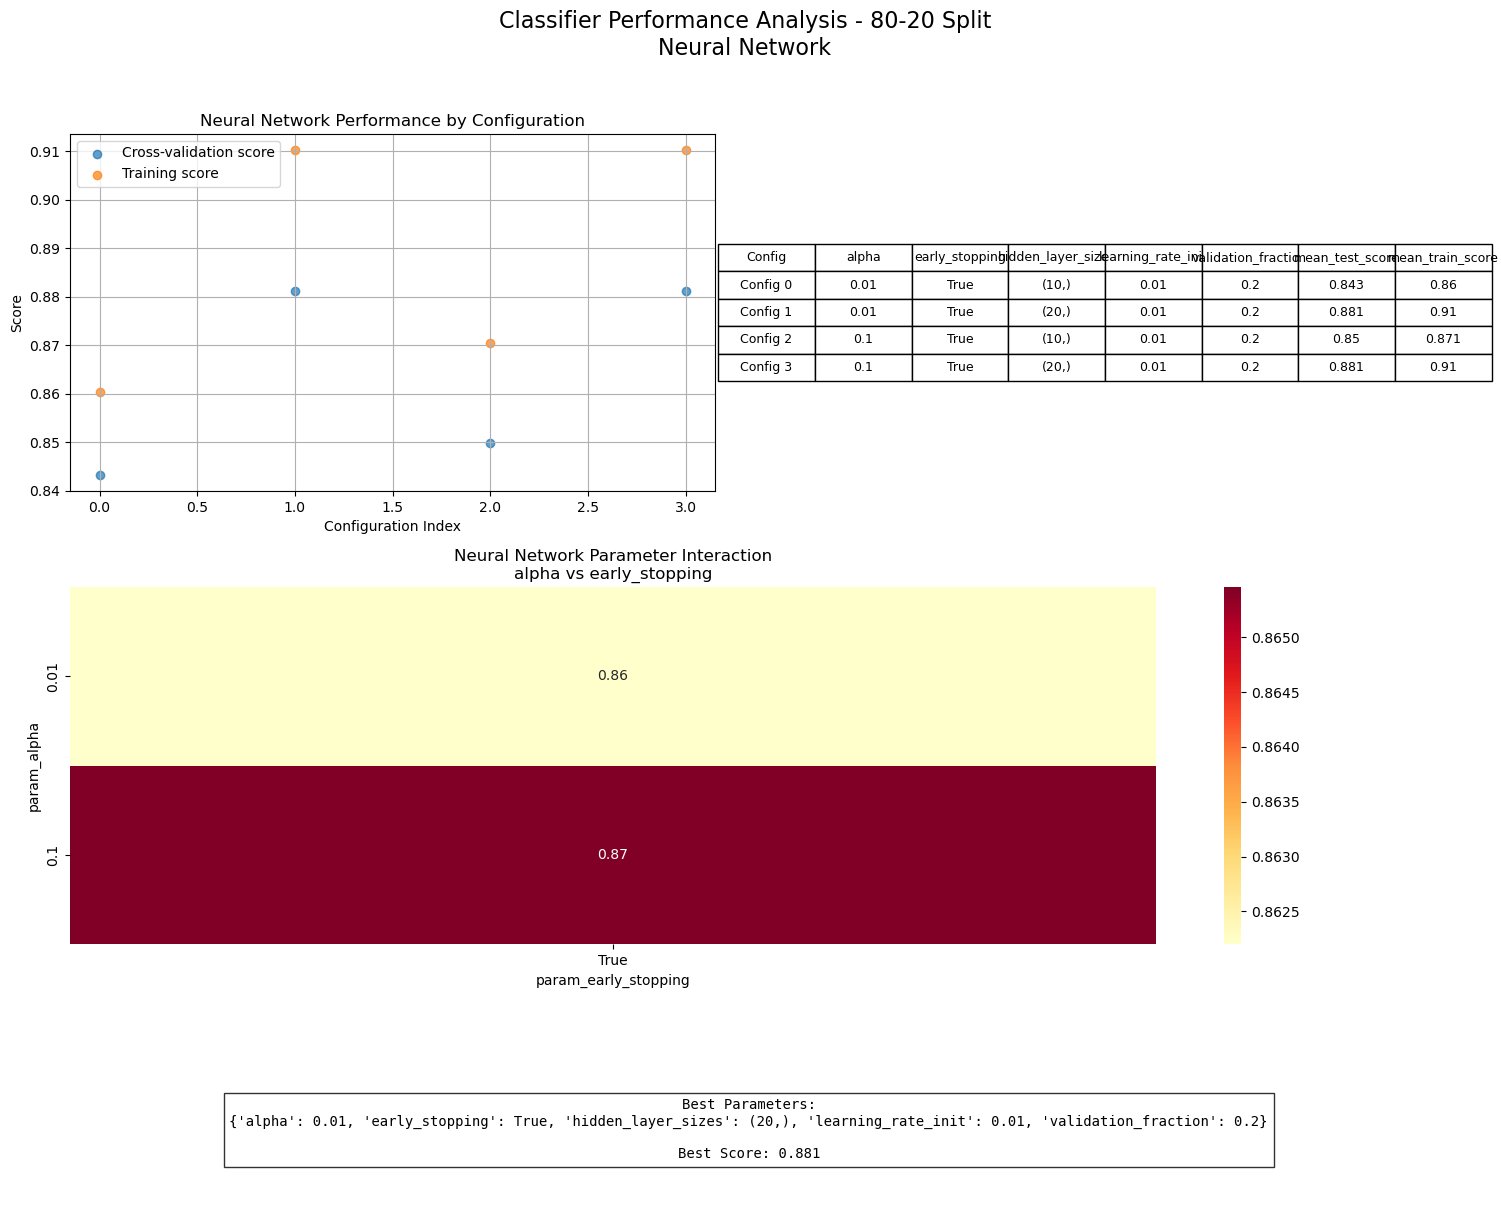

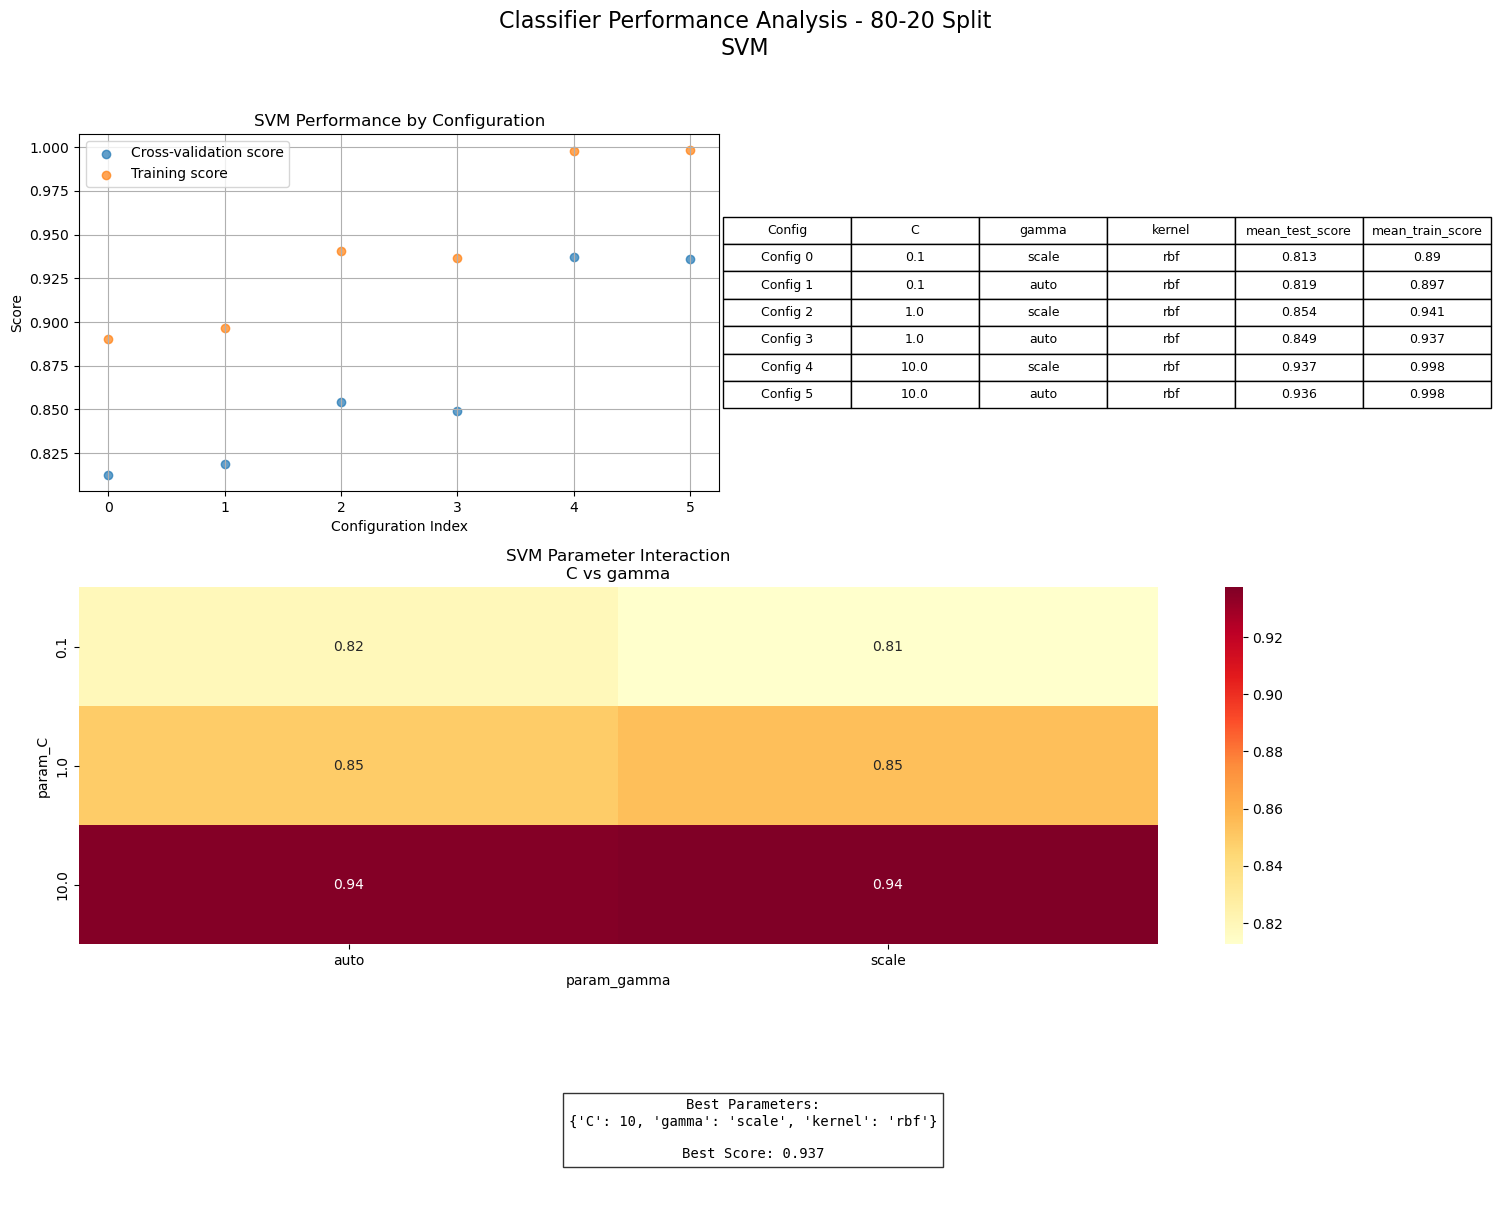


Average Performance:
                      accuracy   roc_auc
split classifier                        
20-80 Neural Network  0.717949  0.561473
      Random Forest   0.878205  0.931405
      SVM             0.826923  0.880342
50-50 Neural Network  0.836735  0.864928
      Random Forest   0.948980  0.962319
      SVM             0.928571  0.974493
80-20 Neural Network  0.871795  0.879464
      Random Forest   0.948718  0.933036
      SVM             0.948718  0.959821


In [10]:
print("Running experiments with cross-validation...")
all_results = []
for trial in range(3):
    trial_results = run_experiment_with_cv(X, y, trial)
    all_results.append(trial_results)

# Combine and analyze results
final_results = pd.concat(all_results, ignore_index=True)
avg_performance = final_results.groupby(['split', 'classifier'])[['accuracy', 'roc_auc']].mean()

# Print results
print("\nAverage Performance:")
print(avg_performance)

In [11]:
# Print best parameters for each classifier
print("\nBest Parameters:")
for clf in final_results['classifier'].unique():
    print(f"\n{clf}:")
    params = final_results[final_results['classifier'] == clf]['best_params'].iloc[0]
    print(params)


Best Parameters:

Random Forest:
{'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}

Neural Network:
{'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (20,), 'learning_rate_init': 0.01, 'validation_fraction': 0.2}

SVM:
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


<Figure size 1200x600 with 0 Axes>

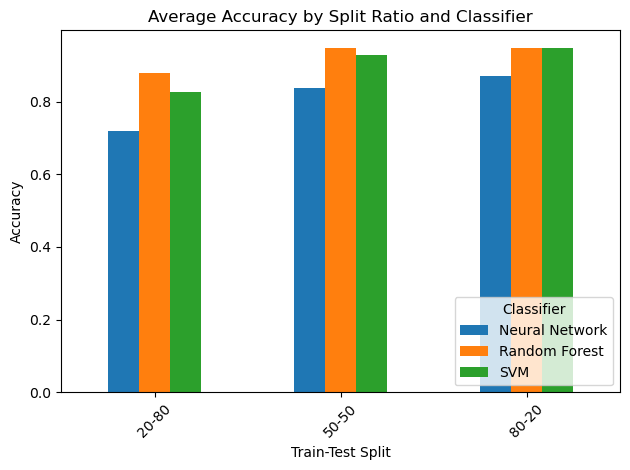

<Figure size 1200x600 with 0 Axes>

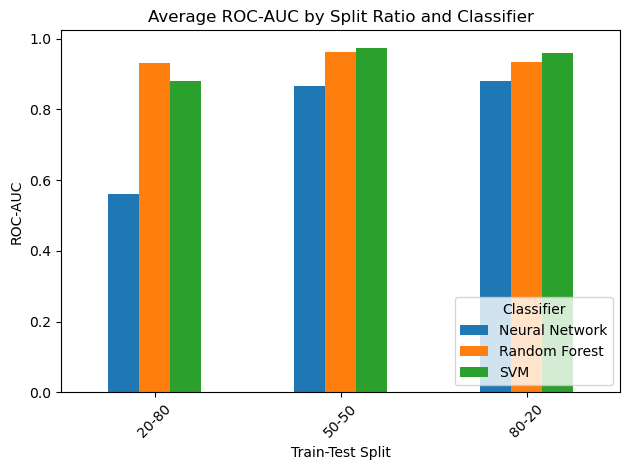

In [12]:
plt.figure(figsize=(12, 6))
avg_performance['accuracy'].unstack().plot(kind='bar')
plt.title('Average Accuracy by Split Ratio and Classifier')
plt.xlabel('Train-Test Split')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend(title='Classifier', loc='lower right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
avg_performance['roc_auc'].unstack().plot(kind='bar')
plt.title('Average ROC-AUC by Split Ratio and Classifier')
plt.xlabel('Train-Test Split')
plt.ylabel('ROC-AUC')
plt.xticks(rotation=45)
plt.legend(title='Classifier', loc='lower right')
plt.tight_layout()
plt.show()